⚡ In this project, I built a couple of UNet-based models for the task of Multiclass Semantic Segmentation of satellite images of Dubai to compare their performance.

I built 5 models including the classic UNet and Vision-Transformer-based UNet (UNETR).
The other 3 models are variations of it (VGG10-UNet, Densenet-121-Unet, Attention-UNet)

In conclusion, using 2088 images to train models, Densenet-121-Unet achieved the best performance with an accuracy of 89% compared to others. The UNETR model achieves around 72.09% accuracy on the test data. However, this is not a competitive result on a rather small dataset compared to CNNs on the same data. CNNs achieve excellent results on data volumes that are not as large as those required by Vision Transformers.

In [4]:
# Import libraries
import os
import cv2
import seaborn as sns
import IPython
import numpy as np
import pandas as pd
from PIL import Image
from patchify import patchify
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Model , load_model
from keras.applications import VGG19
from keras.applications import DenseNet121
from keras.applications import EfficientNetB0
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [5]:
# Image config
img_size = 256
num_channels = 3
input_shape = (img_size, img_size, num_channels)

# Transformers encoder hyperparameters config
patch_size = 16
num_patches = (img_size // patch_size) * (img_size // patch_size)
mlp_dim = 3072  # dimensionality of the hidden layers in the Multi-Layer Perceptron (MLP) component of the mode
num_heads = 12  # Number of attention heads in the multi-head attention layer
hidden_dim = 768 # the size of the feature vectors (embeddings) for representing the input data
dropout_rate= 0.2
transformer_layers = 12 # Number of transformer blocks
flat_patches_shape = (num_patches, patch_size*patch_size*num_channels)

# MinMaxScaler for rescaling each variable to a range of 0-1
scaler = MinMaxScaler()

In [6]:
# The dataset consists of 72 aerial images of Dubai & annotated with pixel-wise semantic segmentation in 6 classes.
# https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
root_folder = './SemanticSegmentationDataset'

In [7]:
# Raw input images are of various sizes, thus we should capture all images into numpy arrays,
# then crop them into the nearest size which is divisible by 256 (img_size), following this cut them into a fixed-size and extract 256X256 patches.
# In total => 1035 patches
img_dataset =[]

for path , subdirs, files in os.walk(root_folder):

    # name of each direcory
    dir_name = path.split(os.path.sep)[-1]

    if dir_name== 'images':
        print('-----------------------------------------------\n', 'Image Directory Path: ', path)

        # list of images in each 'image' directory
        images_lst = os.listdir(path)
        images_lst.sort()

        for i , img in enumerate(images_lst):
            if img.endswith('.jpg'):
                print('-------------------\n', img)

                #read images in RGB
                image = cv2.imread(path+ '/' + img , 1)
                print(' image shape: ',image.shape)

                # images are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (image.shape[1] // img_size) * img_size
                sizeY = (image.shape[0] // img_size) * img_size
                image = Image.fromarray(image)
                image = image.crop((0,0,sizeX,sizeY))

                # convert images into numpy array
                image = np.array(image)

                # cut up images into non-overlapped 256x256 pieces
                patched_imgs = patchify(image , (img_size,img_size,3) , step= img_size)
                print(' patche shape: ',patched_imgs.shape)

                for i in range(patched_imgs.shape[0]):
                    for j in range(patched_imgs.shape[1]):
                        single_patch_img = patched_imgs[i,j,:,:]

                        # normalize images via MinMaxScaler => value between 0 and 1
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]

                        # add all patches to a list
                        img_dataset.append(single_patch_img)

-----------------------------------------------
 Image Directory Path:  ./SemanticSegmentationDataset/Tile 1/images
-------------------
 image_part_001.jpg
 image shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_002.jpg
 image shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_003.jpg
 image shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_004.jpg
 image shape:  (643, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_005.jpg
 image shape:  (643, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_006.jpg
 image shape:  (643, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_007.jpg
 image shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_008.jpg
 image shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------


In [8]:
msk_dataset = []

for path, subdirs, files in os.walk(root_folder):

    # name of each direcory
    dirname = path.split(os.path.sep)[-1]

    if dirname == 'masks':
        print('-----------------------------------------------\n', 'Mask Directory Path: ', path)

        # list of masks in each 'mask' directory
        masks_lst = os.listdir(path)
        masks_lst.sort()


        for i, msk in enumerate(masks_lst):
            if msk.endswith(".png"):
                print('-------------------\n' ,msk)

                #Read each mask as RGB
                mask = cv2.imread(path+"/"+msk, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                print(' mask shape: ', mask.shape)

                # masks are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (mask.shape[1]//img_size)*img_size
                sizeY = (mask.shape[0]//img_size)*img_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, sizeX, sizeY))

                # convert masks into numpy array
                mask = np.array(mask)

                # cut up masks into 256x256 pieces for data augmentation
                patched_masks = patchify(mask , (img_size,img_size,3) , step= img_size)
                print(' patche shape: ', patched_masks.shape)

                for i in range(patched_masks.shape[0]):
                    for j in range(patched_masks.shape[1]):

                        single_patch_mask = patched_masks[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]

                        # add all patched masks to a list
                        msk_dataset.append(single_patch_mask)

-----------------------------------------------
 Mask Directory Path:  ./SemanticSegmentationDataset/Tile 1/masks
-------------------
 image_part_001.png
 mask shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_002.png
 mask shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_003.png
 mask shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_004.png
 mask shape:  (643, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_005.png
 mask shape:  (643, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_006.png
 mask shape:  (643, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_007.png
 mask shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_part_008.png
 mask shape:  (644, 797, 3)
 patche shape:  (2, 3, 1, 256, 256, 3)
-------------------
 image_par

In [9]:
img_dataset = np.array(img_dataset)
msk_dataset =  np.array(msk_dataset)

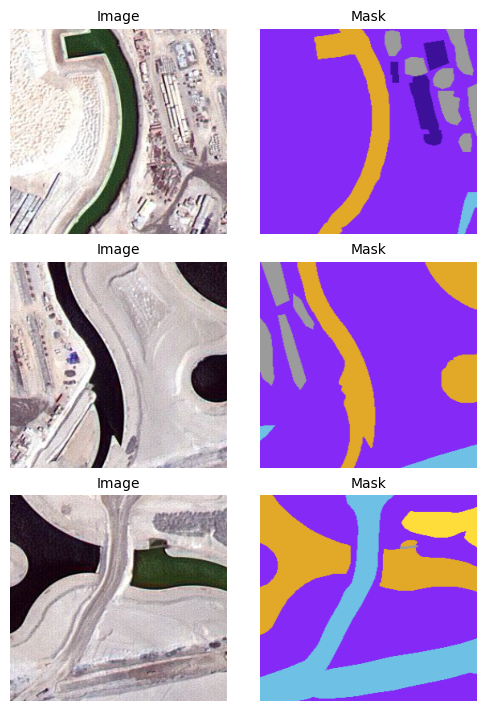

In [10]:
# Visualise patched images & their corresponding masks
count = 0
i = 0
fig, axs = plt.subplots(3, 2, figsize=(5, 7), constrained_layout=True)

for mask in msk_dataset:
    if (mask.all()):
        # read images
        axs[count][0].imshow(cv2.resize(img_dataset[i], (270,256)))
        axs[count][0].set_title('Image', fontdict = {'fontsize':10})
        axs[count][0].axis(False)

        # read masks
        axs[count][1].imshow(cv2.resize(msk_dataset[i], (270,256)))
        axs[count][1].set_title('Mask' , fontdict = {'fontsize':10})
        axs[count][1].axis(False)

        count +=1
    i += 1
    if (count==3):
        break

plt.show()

In [11]:
# Mask are RGB and information is provided in HEX color code, so we need to:
# 1) Convert HEX labels to RGB values--------------------------------------------------------------------------
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))
print('Building :' , Building)

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))
print('Land :' , Land)

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4)))
print('Road :' , Road)

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))
print('Vegetation :' , Vegetation)

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4)))
print('Water :' , Water)

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))
print('Unlabeled :' , Unlabeled)


# 2) Convert RGB labels to integer values--------------------------------------------------------------------------
def rgb_to_2D_label(msk_dt):
    # create a new array of given shape and type of each row of mask dataset, filled with zeros
    label_seg = np.zeros(msk_dt.shape, dtype = np.uint8)

    label_seg [np.all(msk_dt == Building,axis=-1)] = 0
    label_seg [np.all(msk_dt==Land,axis=-1)] = 1
    label_seg [np.all(msk_dt==Road,axis=-1)] = 2
    label_seg [np.all(msk_dt==Vegetation,axis=-1)] = 3
    label_seg [np.all(msk_dt==Water,axis=-1)] = 4
    label_seg [np.all(msk_dt==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]
    return label_seg

labels = []
for i in range(msk_dataset.shape[0]):
    label = rgb_to_2D_label(msk_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
print("-----------------------------")
print(labels.shape)


# 3) one-hot encode labels, since it's a multiclass segmentation task ---------------------------------------------- a way to represent categorical values in a numerical way
print("-----------------------------")
print("all labels : ", np.unique(labels))
num_classes = len(np.unique(labels)) #6
labels_cat = to_categorical(labels, num_classes=num_classes)

Building : [ 60  16 152]
Land : [132  41 246]
Road : [110 193 228]
Vegetation : [254 221  58]
Water : [226 169  41]
Unlabeled : [155 155 155]
-----------------------------
(1305, 256, 256, 1)
-----------------------------
all labels :  [0 1 2 3 4 5]


In [12]:
# split data into training & testing dataset
X_train, X_test, y_train, y_test = train_test_split(img_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [13]:
## Image Augmentation
# Vertical Image
Vx = [np.flip(x, axis=0) for x in X_train]
Vy = [np.flip(x, axis=0) for x in y_train]

X_train = np.append(X_train, Vx, axis=0)
y_train = np.append(y_train, Vy, axis=0)

In [14]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (2088, 256, 256, 3)
y_train shape:  (2088, 256, 256, 6)
X_test shape:  (261, 256, 256, 3)
y_test shape:  (261, 256, 256, 6)


# U-Net Model

In [15]:
# U-net model 2
def encoding_block(inputs, filters, dropout_probability=0, max_pooling=True):

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    skip_connection = C

    if max_pooling:
        next_layer = layers.MaxPooling2D(pool_size=(2, 2))(C)
    else:
        next_layer = C

    return next_layer, skip_connection

In [16]:
def decoding_block(inputs, skip_connection_input, filters):
    CT = layers.Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)

    residual_connection = layers.concatenate([CT, skip_connection_input], axis=3)

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    C = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = layers.BatchNormalization()(C)
    C = layers.Activation("relu")(C)

    return C

In [17]:
def unet_model(input_size, filters, n_classes):
    inputs = layers.Input(input_size)

    # Encoder
    C1, S1 = encoding_block(inputs, filters, max_pooling=True)
    C2, S2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, S3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, S4 = encoding_block(C3, filters * 8, max_pooling=True)

    C5, S5 = encoding_block(C4, filters * 16, max_pooling=False)

    # Decoder
    U6 = decoding_block(C5, S4, filters * 8)
    U7 = decoding_block(U6, S3,  filters * 4)
    U8 = decoding_block(U7, S2,  filters = filters * 2)
    U9 = decoding_block(U8, S1,  filters = filters)

    C10 = layers.Conv2D(filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(U9)

    C11 = layers.Conv2D(filters = n_classes, kernel_size = (1,1), activation='softmax', padding='same')(C10)

    model = Model(inputs=inputs, outputs=C11)

    return model

In [18]:
unet_model = unet_model((img_size, img_size, num_channels), filters=32, n_classes=num_classes)
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0][0

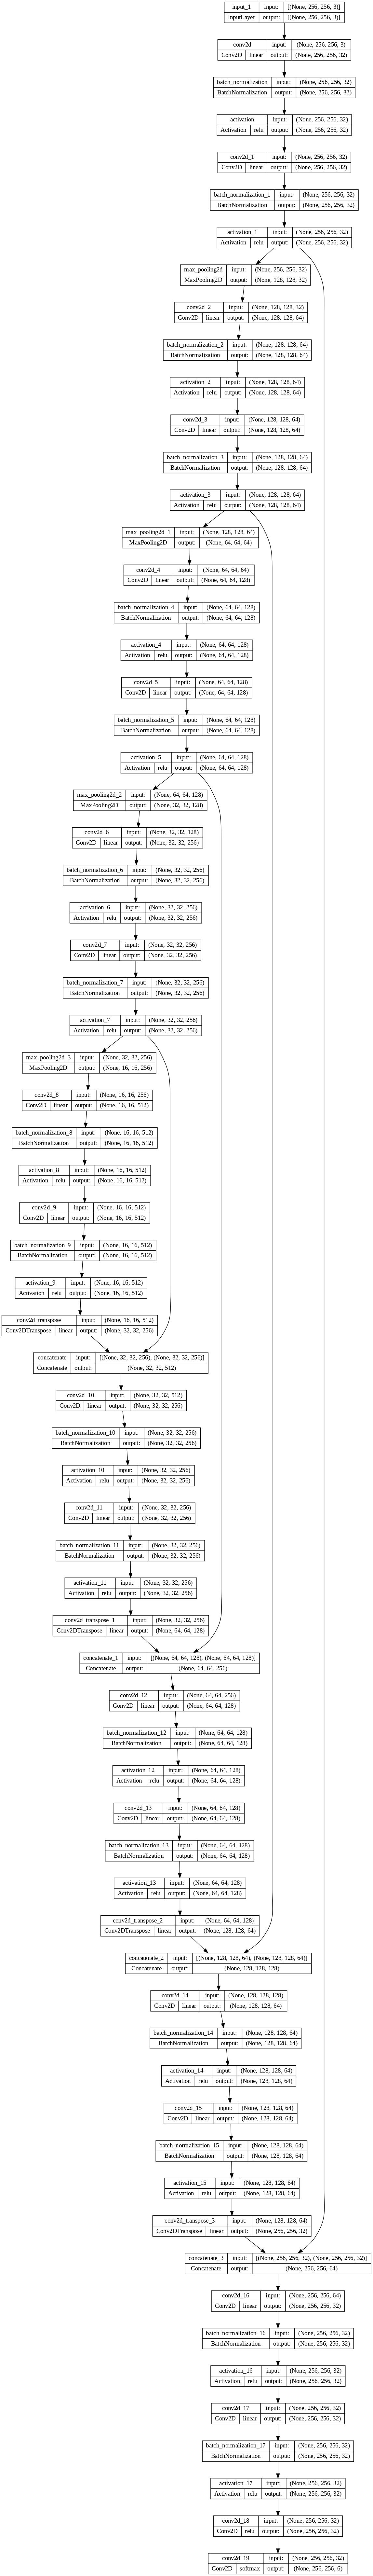

In [ ]:
keras.utils.plot_model(
    unet_model,
    to_file='UNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [19]:
# compile the model
unet_model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

checkpoint_unet = ModelCheckpoint("./CNN_UNet.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping_unet = EarlyStopping(monitor='val_acc', patience=20,verbose=1, restore_best_weights=True)
reduce_learningrate_unet = ReduceLROnPlateau(monitor='val_acc',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

callbacks_list_unet = [early_stopping_unet,checkpoint_unet,reduce_learningrate_unet]

In [20]:
history_unet = unet_model.fit(X_train, y_train, batch_size = 16, verbose=1, epochs= 30, validation_data=(X_test, y_test), callbacks = callbacks_list_unet)

Epoch 1/30
131/131 [==============================] - ETA: 0s - loss: 0.7748 - accuracy: 0.7309

131/131 [==============================] - 36s 124ms/step - loss: 0.7748 - accuracy: 0.7309 - val_loss: 1.7890 - val_accuracy: 0.5810 - lr: 0.0010
Epoch 2/30
130/131 [============================>.] - ETA: 0s - loss: 0.6495 - accuracy: 0.7761

131/131 [==============================] - 11s 80ms/step - loss: 0.6491 - accuracy: 0.7760 - val_loss: 1.2652 - val_accuracy: 0.6976 - lr: 0.0010
Epoch 3/30
130/131 [============================>.] - ETA: 0s - loss: 0.6007 - accuracy: 0.7924

131/131 [==============================] - 11s 81ms/step - loss: 0.6008 - accuracy: 0.7923 - val_loss: 0.6626 - val_accuracy: 0.7673 - lr: 0.0010
Epoch 4/30
130/131 [============================>.] - ETA: 0s - loss: 0.5716 - accuracy: 0.8037

131/131 [==============================] - 11s 81ms/step - loss: 0.5720 - accuracy: 0.8037 - val_loss: 0.5873 - val_accuracy: 0.8008 - lr: 0.0010
Epoch 5/30
130/131 [============================>.] - ETA: 0s - loss: 0.5423 - accuracy: 0.8146

131/131 [==============================] - 11s 80ms/step - loss: 0.5428 - accuracy: 0.8142 - val_loss: 0.6083 - val_accuracy: 0.7944 - lr: 0.0010
Epoch 6/30
130/131 [============================>.] - ETA: 0s - loss: 0.5269 - accuracy: 0.8175

131/131 [==============================] - 11s 80ms/step - loss: 0.5268 - accuracy: 0.8177 - val_loss: 0.5040 - val_accuracy: 0.8269 - lr: 0.0010
Epoch 7/30
130/131 [============================>.] - ETA: 0s - loss: 0.5108 - accuracy: 0.8236

131/131 [==============================] - 11s 81ms/step - loss: 0.5111 - accuracy: 0.8234 - val_loss: 0.5027 - val_accuracy: 0.8271 - lr: 0.0010
Epoch 8/30
130/131 [============================>.] - ETA: 0s - loss: 0.4991 - accuracy: 0.8265

131/131 [==============================] - 11s 80ms/step - loss: 0.4996 - accuracy: 0.8265 - val_loss: 0.5989 - val_accuracy: 0.7903 - lr: 0.0010
Epoch 9/30
130/131 [============================>.] - ETA: 0s - loss: 0.4853 - accuracy: 0.8330

131/131 [==============================] - 11s 81ms/step - loss: 0.4859 - accuracy: 0.8328 - val_loss: 0.5773 - val_accuracy: 0.8025 - lr: 0.0010
Epoch 10/30
130/131 [============================>.] - ETA: 0s - loss: 0.4752 - accuracy: 0.8345

131/131 [==============================] - 11s 81ms/step - loss: 0.4750 - accuracy: 0.8346 - val_loss: 0.4637 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 11/30
130/131 [============================>.] - ETA: 0s - loss: 0.4657 - accuracy: 0.8384

131/131 [==============================] - 11s 81ms/step - loss: 0.4660 - accuracy: 0.8382 - val_loss: 0.7090 - val_accuracy: 0.7586 - lr: 0.0010
Epoch 12/30
130/131 [============================>.] - ETA: 0s - loss: 0.4571 - accuracy: 0.8405

131/131 [==============================] - 11s 81ms/step - loss: 0.4567 - accuracy: 0.8406 - val_loss: 0.4693 - val_accuracy: 0.8395 - lr: 0.0010
Epoch 13/30
130/131 [============================>.] - ETA: 0s - loss: 0.4454 - accuracy: 0.8439

131/131 [==============================] - 11s 81ms/step - loss: 0.4459 - accuracy: 0.8437 - val_loss: 0.5219 - val_accuracy: 0.8172 - lr: 0.0010
Epoch 14/30
130/131 [============================>.] - ETA: 0s - loss: 0.4371 - accuracy: 0.8473

131/131 [==============================] - 11s 81ms/step - loss: 0.4386 - accuracy: 0.8470 - val_loss: 0.4825 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 15/30
130/131 [============================>.] - ETA: 0s - loss: 0.4295 - accuracy: 0.8483

131/131 [==============================] - 11s 81ms/step - loss: 0.4289 - accuracy: 0.8485 - val_loss: 0.5646 - val_accuracy: 0.8263 - lr: 0.0010
Epoch 16/30
130/131 [============================>.] - ETA: 0s - loss: 0.4354 - accuracy: 0.8470

131/131 [==============================] - 11s 81ms/step - loss: 0.4357 - accuracy: 0.8468 - val_loss: 0.4983 - val_accuracy: 0.8307 - lr: 0.0010
Epoch 17/30
130/131 [============================>.] - ETA: 0s - loss: 0.4219 - accuracy: 0.8509

131/131 [==============================] - 11s 81ms/step - loss: 0.4225 - accuracy: 0.8506 - val_loss: 0.5567 - val_accuracy: 0.8244 - lr: 0.0010
Epoch 18/30
130/131 [============================>.] - ETA: 0s - loss: 0.4197 - accuracy: 0.8518

131/131 [==============================] - 11s 81ms/step - loss: 0.4208 - accuracy: 0.8516 - val_loss: 0.4742 - val_accuracy: 0.8430 - lr: 0.0010
Epoch 19/30
130/131 [============================>.] - ETA: 0s - loss: 0.4138 - accuracy: 0.8540

131/131 [==============================] - 11s 81ms/step - loss: 0.4143 - accuracy: 0.8538 - val_loss: 0.4716 - val_accuracy: 0.8349 - lr: 0.0010
Epoch 20/30
130/131 [============================>.] - ETA: 0s - loss: 0.4002 - accuracy: 0.8583

131/131 [==============================] - 11s 81ms/step - loss: 0.4004 - accuracy: 0.8581 - val_loss: 0.4463 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 21/30
130/131 [============================>.] - ETA: 0s - loss: 0.3989 - accuracy: 0.8573

131/131 [==============================] - 11s 81ms/step - loss: 0.3989 - accuracy: 0.8573 - val_loss: 0.4524 - val_accuracy: 0.8397 - lr: 0.0010
Epoch 22/30
130/131 [============================>.] - ETA: 0s - loss: 0.3876 - accuracy: 0.8621

131/131 [==============================] - 11s 81ms/step - loss: 0.3891 - accuracy: 0.8617 - val_loss: 0.4576 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 23/30
130/131 [============================>.] - ETA: 0s - loss: 0.3982 - accuracy: 0.8589

131/131 [==============================] - 11s 81ms/step - loss: 0.3987 - accuracy: 0.8587 - val_loss: 0.5593 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 24/30
130/131 [============================>.] - ETA: 0s - loss: 0.3819 - accuracy: 0.8648

131/131 [==============================] - 11s 81ms/step - loss: 0.3821 - accuracy: 0.8647 - val_loss: 0.4056 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 25/30
130/131 [============================>.] - ETA: 0s - loss: 0.3808 - accuracy: 0.8643

131/131 [==============================] - 11s 81ms/step - loss: 0.3807 - accuracy: 0.8643 - val_loss: 0.4886 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 26/30
130/131 [============================>.] - ETA: 0s - loss: 0.3786 - accuracy: 0.8650

131/131 [==============================] - 11s 81ms/step - loss: 0.3787 - accuracy: 0.8650 - val_loss: 0.5640 - val_accuracy: 0.7994 - lr: 0.0010
Epoch 27/30
130/131 [============================>.] - ETA: 0s - loss: 0.3900 - accuracy: 0.8615

131/131 [==============================] - 11s 81ms/step - loss: 0.3896 - accuracy: 0.8616 - val_loss: 0.5541 - val_accuracy: 0.8050 - lr: 0.0010
Epoch 28/30
130/131 [============================>.] - ETA: 0s - loss: 0.3740 - accuracy: 0.8671

131/131 [==============================] - 11s 81ms/step - loss: 0.3744 - accuracy: 0.8669 - val_loss: 0.5009 - val_accuracy: 0.8222 - lr: 0.0010
Epoch 29/30
130/131 [============================>.] - ETA: 0s - loss: 0.3598 - accuracy: 0.8717

131/131 [==============================] - 11s 81ms/step - loss: 0.3597 - accuracy: 0.8718 - val_loss: 0.4292 - val_accuracy: 0.8430 - lr: 0.0010
Epoch 30/30
130/131 [============================>.] - ETA: 0s - loss: 0.3556 - accuracy: 0.8723

131/131 [==============================] - 11s 81ms/step - loss: 0.3556 - accuracy: 0.8723 - val_loss: 0.4284 - val_accuracy: 0.8556 - lr: 0.0010


In [21]:
df_result_unet = pd.DataFrame(history_unet.history)
df_result_unet

loss  accuracy  val_loss  val_accuracy     lr
0   0.774779  0.730913  1.788976      0.581013  0.001
1   0.649076  0.776003  1.265245      0.697585  0.001
2   0.600793  0.792328  0.662564      0.767343  0.001
3   0.572035  0.803685  0.587265      0.800758  0.001
4   0.542761  0.814248  0.608258      0.794441  0.001
5   0.526773  0.817660  0.504010      0.826894  0.001
6   0.511114  0.823371  0.502693      0.827054  0.001
7   0.499628  0.826453  0.598938      0.790334  0.001
8   0.485949  0.832822  0.577289      0.802544  0.001
9   0.474959  0.834572  0.463650      0.840004  0.001
10  0.466041  0.838188  0.709029      0.758553  0.001
11  0.456710  0.840621  0.469269      0.839527  0.001
12  0.445892  0.843654  0.521870      0.817156  0.001
13  0.438588  0.846959  0.482527      0.833816  0.001
14  0.428935  0.848500  0.564564      0.826336  0.001
15  0.435699  0.846799  0.498271      0.830702  0.001
16  0.422544  0.850576  0.556699      0.824410  0.001
17  0.420810  0.851589  0.474210      0.842964  0.001
18  0.414262  0.853837  0.471637      0.834928  0.001
19  0.400420  0.858140  0.446304      0.841666  0.001
20  0.398926  0.857327  0.452417      0.839717  0.001
21  0.389137  0.861699  0.457595      0.843297  0.001
22  0.398715  0.858710  0.559338      0.795987  0.001
23  0.382103  0.864689  0.405616      0.858258  0.001
24  0.380730  0.864318  0.488589      0.833043  0.001
25  0.378682  0.865004  0.564001      0.799441  0.001
26  0.389625  0.861588  0.554054      0.805049  0.001
27  0.374378  0.866861  0.500863      0.822205  0.001
28  0.359694  0.871806  0.429171      0.842998  0.001
29  0.355550  0.872327  0.428363      0.855624  0.001

In [22]:
# evalute model
loss_unet,acc_unet= unet_model.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc_unet)

9/9 [==============================] - 3s 47ms/step - loss: 0.4284 - accuracy: 0.8556
accuracy: 0.855624258518219


<Axes: >

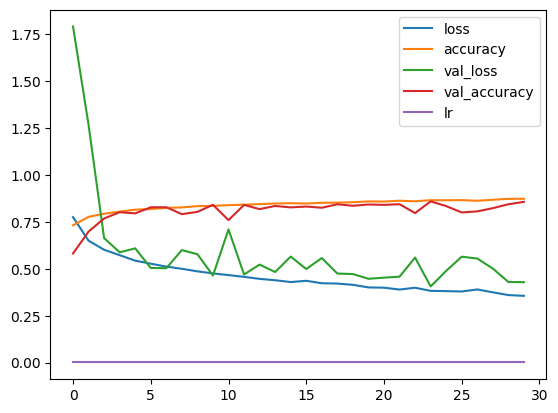

In [23]:
pd.DataFrame(history_unet.history).plot()

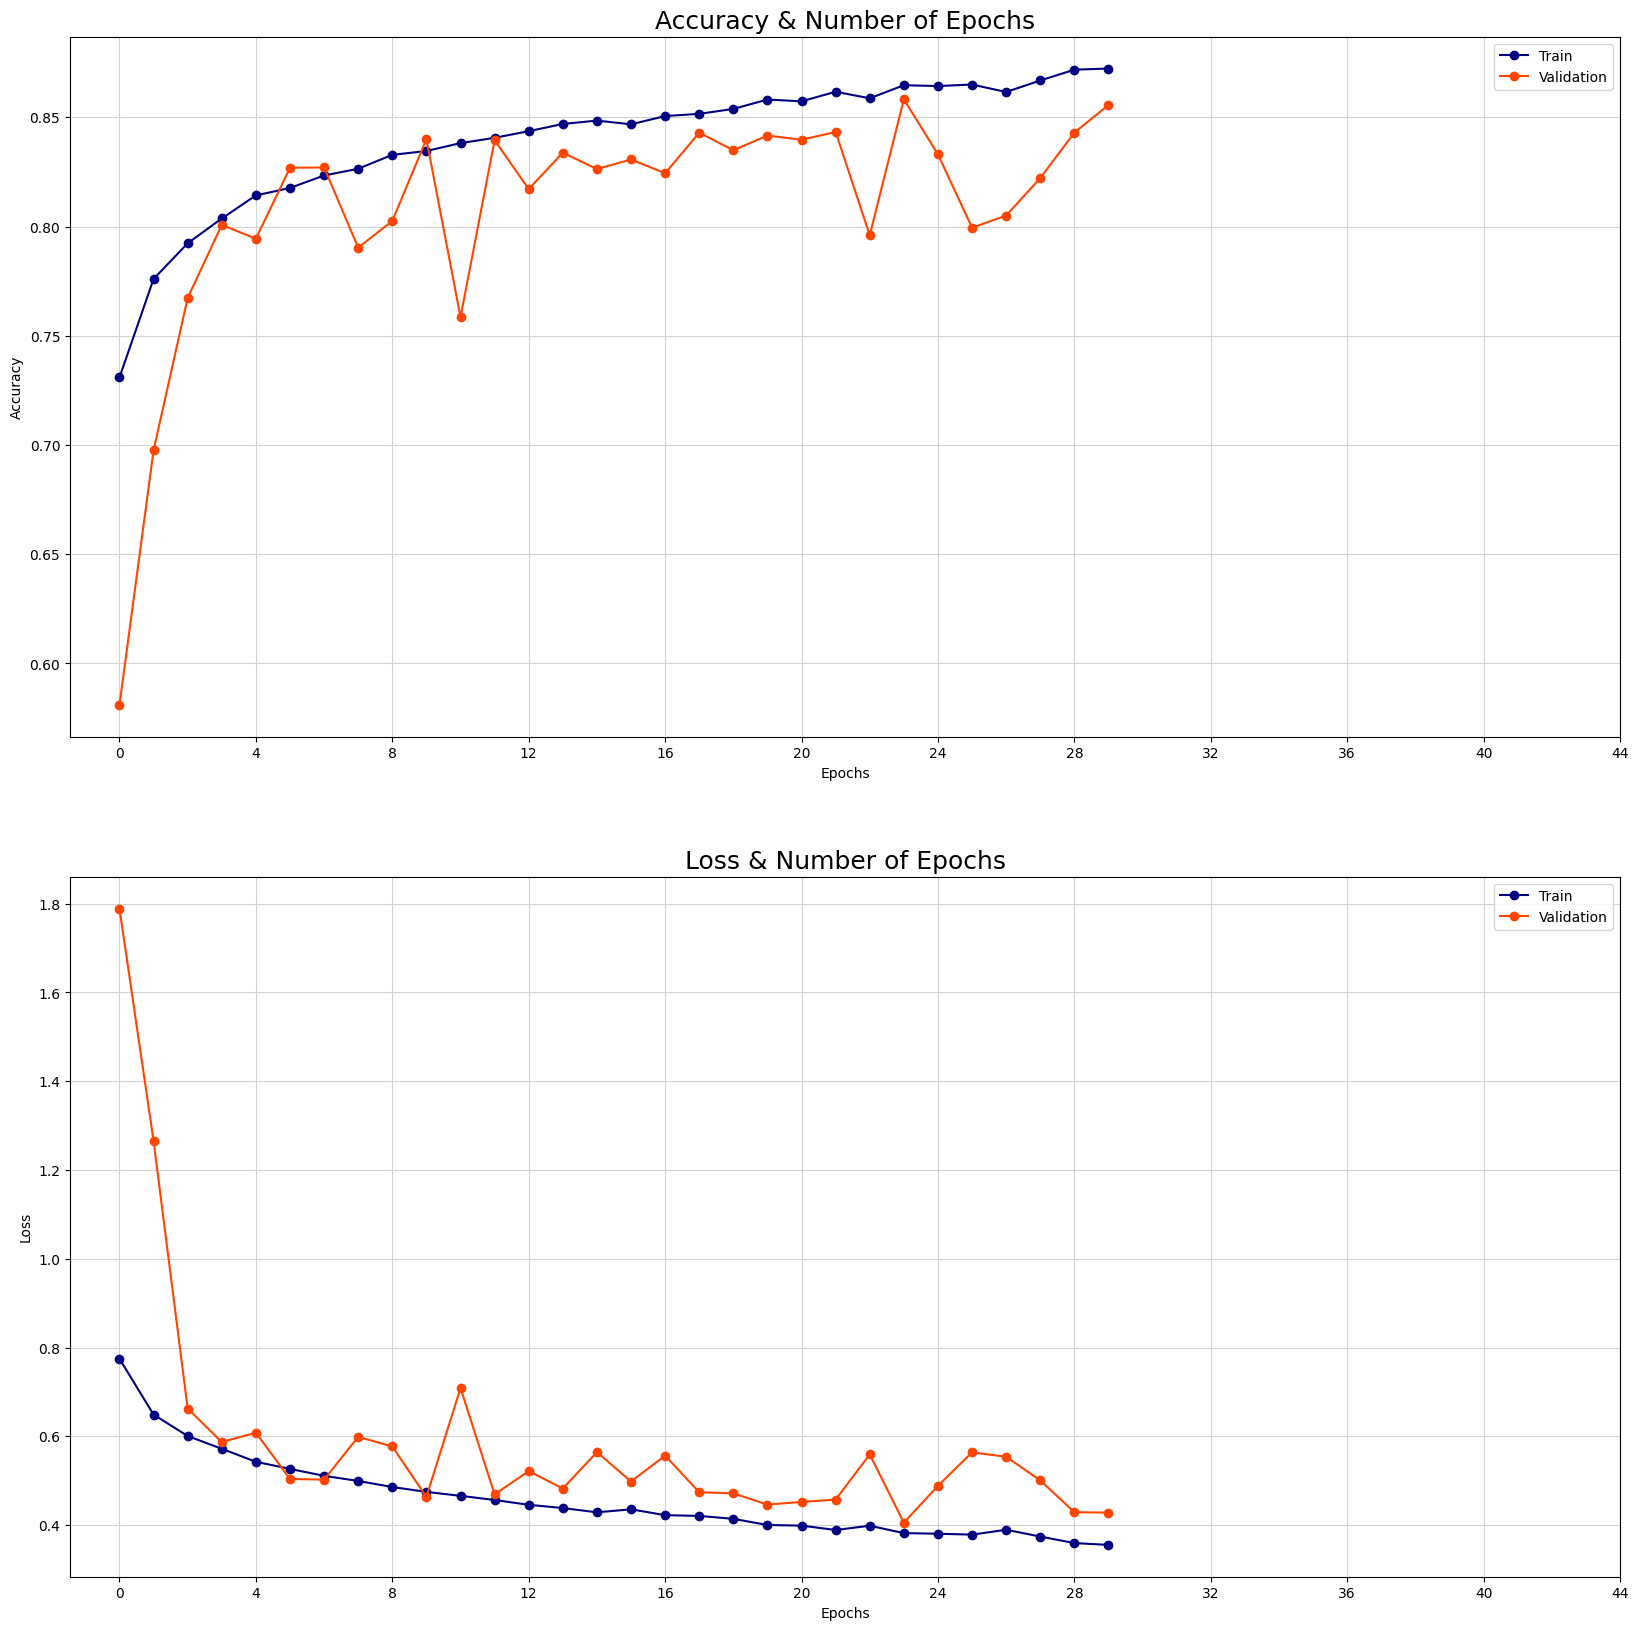

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_unet = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_unet.history[met], 'o-',color= 'navy')
    ax[i].plot(history_unet.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_unet[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_unet[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")


In [25]:
unet_model.save("./CNN_Unet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#VGG19 U-Net Model

In [26]:
# VGG19 model

def conv_block_VGG19(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def decoder_block_VGG19(inputs, skip_connection_input, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_connection_input])
    x = conv_block_VGG19(x, num_filters)
    return x

In [27]:
def VGG19_unet(input_size,n_classes):
    inputs = layers.Input(input_size)
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    # encoder
    s1 = vgg19.get_layer("block1_conv2").output      # (256 x 256)
    s2 = vgg19.get_layer("block2_conv2").output      # (128 x 128)
    s3 = vgg19.get_layer("block3_conv4").output      # (64 x 64)
    s4 = vgg19.get_layer("block4_conv4").output      # (32 x 32)

    # bridge
    b1 = vgg19.get_layer("block5_conv4").output       # (16 x 16)

    # decoder
    d1 = decoder_block_VGG19(b1, s4, 256)
    d2 = decoder_block_VGG19(d1, s3, 128)
    d3 = decoder_block_VGG19(d2, s2, 64)
    d4 = decoder_block_VGG19(d3, s1, 32)

    # output
    dropout = layers.Dropout(0.3)(d4)
    outputs = layers.Conv2D(n_classes, 1, padding="same", activation="softmax")(dropout)

    model_VGG19 = Model(inputs, outputs, name="VGG19-UNet")
    return model_VGG19

In [28]:
model_VGG19 = VGG19_unet((img_size, img_size, num_channels), num_classes)
model_VGG19.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "VGG19-UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                        

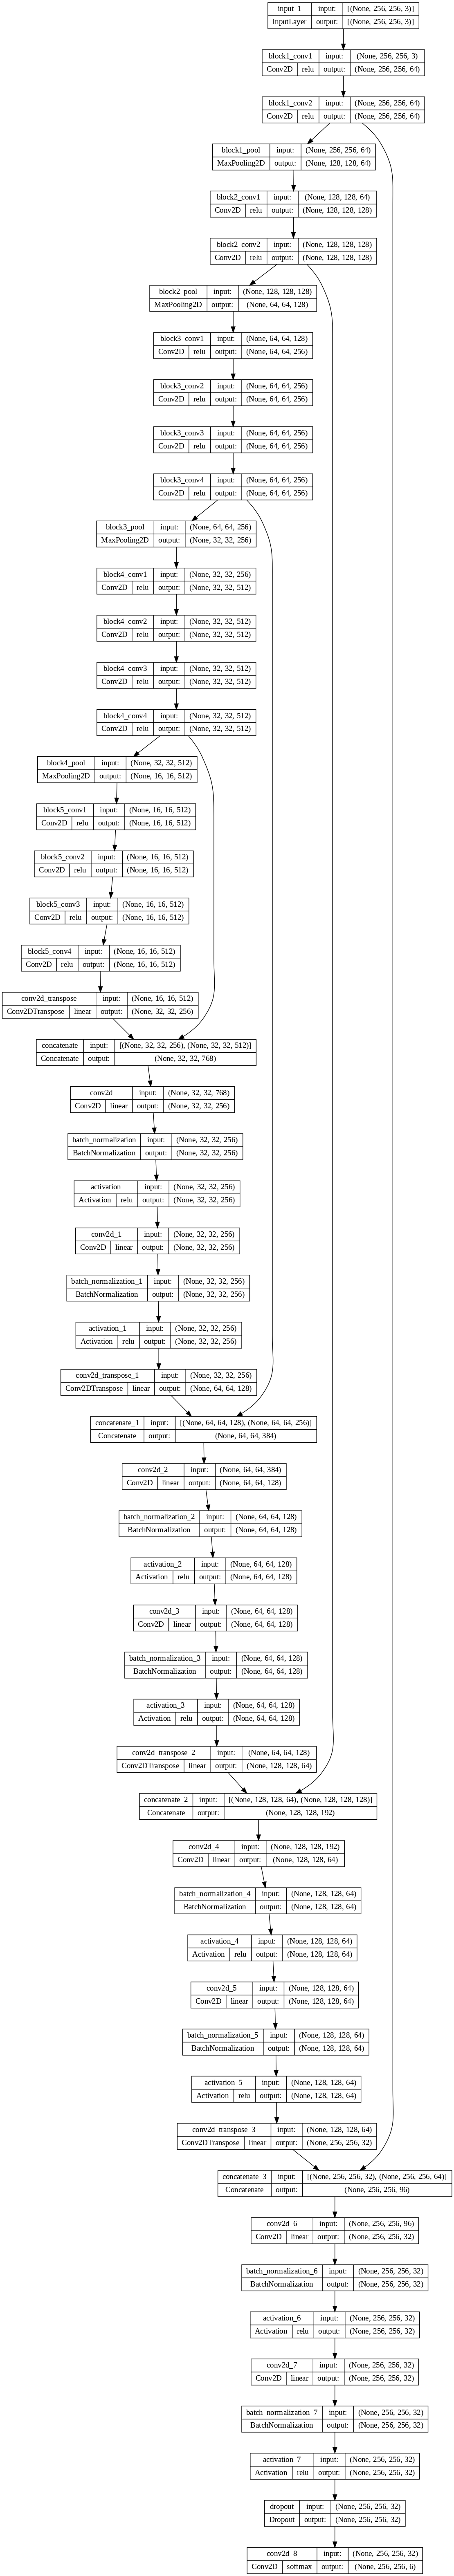

In [ ]:
keras.utils.plot_model(
    model_VGG19,
    to_file='VGG19_UNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [29]:
# compile the model
model_VGG19.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

checkpoint_VGG19 = ModelCheckpoint("./VGG19_UNet.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping_VGG19 = EarlyStopping(monitor='val_acc', patience=20,verbose=1, restore_best_weights=True)
reduce_learningrate_VGG19 = ReduceLROnPlateau(monitor='val_acc',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

callbacks_list_VGG19 = [early_stopping_VGG19,checkpoint_VGG19,reduce_learningrate_VGG19]

In [30]:
history_VGG19 = model_VGG19.fit(X_train, y_train, batch_size = 16, verbose=1, epochs= 30, validation_data=(X_test, y_test), callbacks = callbacks_list_VGG19)

Epoch 1/30
131/131 [==============================] - ETA: 0s - loss: 0.9364 - accuracy: 0.7177

131/131 [==============================] - 65s 218ms/step - loss: 0.9364 - accuracy: 0.7177 - val_loss: 2.5734 - val_accuracy: 0.6105 - lr: 0.0010
Epoch 2/30
131/131 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.7876

131/131 [==============================] - 14s 103ms/step - loss: 0.6698 - accuracy: 0.7876 - val_loss: 0.6937 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 3/30
131/131 [==============================] - ETA: 0s - loss: 0.6113 - accuracy: 0.8020

131/131 [==============================] - 14s 104ms/step - loss: 0.6113 - accuracy: 0.8020 - val_loss: 0.5409 - val_accuracy: 0.8198 - lr: 0.0010
Epoch 4/30
131/131 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.8139

131/131 [==============================] - 14s 103ms/step - loss: 0.5697 - accuracy: 0.8139 - val_loss: 0.6132 - val_accuracy: 0.7819 - lr: 0.0010
Epoch 5/30
131/131 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.8237

131/131 [==============================] - 14s 103ms/step - loss: 0.5363 - accuracy: 0.8237 - val_loss: 0.5217 - val_accuracy: 0.8211 - lr: 0.0010
Epoch 6/30
131/131 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.8219

131/131 [==============================] - 13s 103ms/step - loss: 0.5394 - accuracy: 0.8219 - val_loss: 0.5541 - val_accuracy: 0.8136 - lr: 0.0010
Epoch 7/30
131/131 [==============================] - ETA: 0s - loss: 0.5112 - accuracy: 0.8318

131/131 [==============================] - 14s 103ms/step - loss: 0.5112 - accuracy: 0.8318 - val_loss: 0.5162 - val_accuracy: 0.8135 - lr: 0.0010
Epoch 8/30
131/131 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.8282

131/131 [==============================] - 14s 103ms/step - loss: 0.5163 - accuracy: 0.8282 - val_loss: 0.4994 - val_accuracy: 0.8274 - lr: 0.0010
Epoch 9/30
131/131 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.8353

131/131 [==============================] - 14s 103ms/step - loss: 0.4911 - accuracy: 0.8353 - val_loss: 0.4497 - val_accuracy: 0.8455 - lr: 0.0010
Epoch 10/30
131/131 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.8409

131/131 [==============================] - 14s 104ms/step - loss: 0.4745 - accuracy: 0.8409 - val_loss: 0.4811 - val_accuracy: 0.8341 - lr: 0.0010
Epoch 11/30
131/131 [==============================] - ETA: 0s - loss: 0.4679 - accuracy: 0.8420

131/131 [==============================] - 14s 103ms/step - loss: 0.4679 - accuracy: 0.8420 - val_loss: 0.4381 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 12/30
131/131 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.8470

131/131 [==============================] - 13s 103ms/step - loss: 0.4523 - accuracy: 0.8470 - val_loss: 0.4296 - val_accuracy: 0.8521 - lr: 0.0010
Epoch 13/30
131/131 [==============================] - ETA: 0s - loss: 0.4705 - accuracy: 0.8417

131/131 [==============================] - 13s 103ms/step - loss: 0.4705 - accuracy: 0.8417 - val_loss: 0.4540 - val_accuracy: 0.8465 - lr: 0.0010
Epoch 14/30
131/131 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.8468

131/131 [==============================] - 14s 103ms/step - loss: 0.4546 - accuracy: 0.8468 - val_loss: 0.4581 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 15/30
131/131 [==============================] - ETA: 0s - loss: 0.4375 - accuracy: 0.8519

131/131 [==============================] - 13s 103ms/step - loss: 0.4375 - accuracy: 0.8519 - val_loss: 0.4072 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 16/30
131/131 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.8548

131/131 [==============================] - 14s 103ms/step - loss: 0.4273 - accuracy: 0.8548 - val_loss: 0.4323 - val_accuracy: 0.8515 - lr: 0.0010
Epoch 17/30
131/131 [==============================] - ETA: 0s - loss: 0.4214 - accuracy: 0.8561

131/131 [==============================] - 13s 103ms/step - loss: 0.4214 - accuracy: 0.8561 - val_loss: 0.4036 - val_accuracy: 0.8588 - lr: 0.0010
Epoch 18/30
131/131 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8570

131/131 [==============================] - 13s 103ms/step - loss: 0.4166 - accuracy: 0.8570 - val_loss: 0.4200 - val_accuracy: 0.8538 - lr: 0.0010
Epoch 19/30
131/131 [==============================] - ETA: 0s - loss: 0.4315 - accuracy: 0.8519

131/131 [==============================] - 13s 103ms/step - loss: 0.4315 - accuracy: 0.8519 - val_loss: 0.3998 - val_accuracy: 0.8564 - lr: 0.0010
Epoch 20/30
131/131 [==============================] - ETA: 0s - loss: 0.4037 - accuracy: 0.8617

131/131 [==============================] - 13s 103ms/step - loss: 0.4037 - accuracy: 0.8617 - val_loss: 0.4327 - val_accuracy: 0.8534 - lr: 0.0010
Epoch 21/30
131/131 [==============================] - ETA: 0s - loss: 0.3963 - accuracy: 0.8643

131/131 [==============================] - 13s 103ms/step - loss: 0.3963 - accuracy: 0.8643 - val_loss: 0.3864 - val_accuracy: 0.8662 - lr: 0.0010
Epoch 22/30
131/131 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8656

131/131 [==============================] - 14s 103ms/step - loss: 0.3927 - accuracy: 0.8656 - val_loss: 0.4228 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 23/30
131/131 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.8661

131/131 [==============================] - 13s 103ms/step - loss: 0.3916 - accuracy: 0.8661 - val_loss: 0.3854 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 24/30
131/131 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8666

131/131 [==============================] - 13s 103ms/step - loss: 0.3870 - accuracy: 0.8666 - val_loss: 0.4430 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 25/30
131/131 [==============================] - ETA: 0s - loss: 0.3735 - accuracy: 0.8717

131/131 [==============================] - 13s 103ms/step - loss: 0.3735 - accuracy: 0.8717 - val_loss: 0.3963 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 26/30
131/131 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.8753

131/131 [==============================] - 14s 103ms/step - loss: 0.3635 - accuracy: 0.8753 - val_loss: 0.3910 - val_accuracy: 0.8718 - lr: 0.0010
Epoch 27/30
131/131 [==============================] - ETA: 0s - loss: 0.3644 - accuracy: 0.8753

131/131 [==============================] - 14s 103ms/step - loss: 0.3644 - accuracy: 0.8753 - val_loss: 0.3830 - val_accuracy: 0.8697 - lr: 0.0010
Epoch 28/30
131/131 [==============================] - ETA: 0s - loss: 0.3615 - accuracy: 0.8764

131/131 [==============================] - 13s 103ms/step - loss: 0.3615 - accuracy: 0.8764 - val_loss: 0.3769 - val_accuracy: 0.8731 - lr: 0.0010
Epoch 29/30
131/131 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.8773

131/131 [==============================] - 13s 103ms/step - loss: 0.3578 - accuracy: 0.8773 - val_loss: 0.4175 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 30/30
131/131 [==============================] - ETA: 0s - loss: 0.3438 - accuracy: 0.8821

131/131 [==============================] - 14s 103ms/step - loss: 0.3438 - accuracy: 0.8821 - val_loss: 0.4143 - val_accuracy: 0.8621 - lr: 0.0010


In [31]:
df_result_VGG19 = pd.DataFrame(history_VGG19.history)
df_result_VGG19

loss  accuracy  val_loss  val_accuracy     lr
0   0.936406  0.717658  2.573439      0.610530  0.001
1   0.669828  0.787617  0.693735      0.776968  0.001
2   0.611293  0.801958  0.540927      0.819762  0.001
3   0.569651  0.813924  0.613194      0.781950  0.001
4   0.536346  0.823674  0.521698      0.821099  0.001
5   0.539430  0.821935  0.554131      0.813633  0.001
6   0.511155  0.831782  0.516245      0.813546  0.001
7   0.516257  0.828249  0.499439      0.827357  0.001
8   0.491132  0.835331  0.449743      0.845487  0.001
9   0.474502  0.840891  0.481115      0.834073  0.001
10  0.467901  0.841993  0.438114      0.846742  0.001
11  0.452266  0.847035  0.429572      0.852139  0.001
12  0.470533  0.841683  0.453977      0.846479  0.001
13  0.454625  0.846835  0.458099      0.836542  0.001
14  0.437487  0.851922  0.407208      0.856679  0.001
15  0.427342  0.854787  0.432295      0.851501  0.001
16  0.421392  0.856051  0.403614      0.858815  0.001
17  0.416554  0.856981  0.419970      0.853847  0.001
18  0.431531  0.851886  0.399789      0.856363  0.001
19  0.403678  0.861669  0.432731      0.853417  0.001
20  0.396349  0.864330  0.386410      0.866218  0.001
21  0.392708  0.865575  0.422834      0.851877  0.001
22  0.391631  0.866139  0.385371      0.867605  0.001
23  0.387033  0.866608  0.443034      0.846791  0.001
24  0.373524  0.871658  0.396313      0.866403  0.001
25  0.363480  0.875348  0.390988      0.871844  0.001
26  0.364404  0.875307  0.382953      0.869725  0.001
27  0.361485  0.876443  0.376879      0.873117  0.001
28  0.357799  0.877305  0.417487      0.865273  0.001
29  0.343756  0.882085  0.414260      0.862117  0.001

In [32]:
# evalute model
loss_VGG19,acc_VGG19= model_VGG19.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc_VGG19)

9/9 [==============================] - 4s 54ms/step - loss: 0.4143 - accuracy: 0.8621
accuracy: 0.8621176481246948


<Axes: >

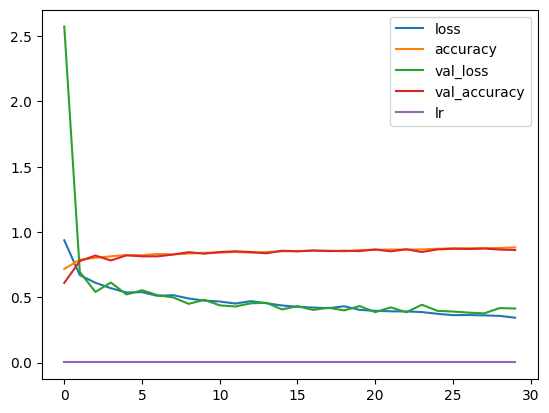

In [33]:
pd.DataFrame(history_VGG19.history).plot()

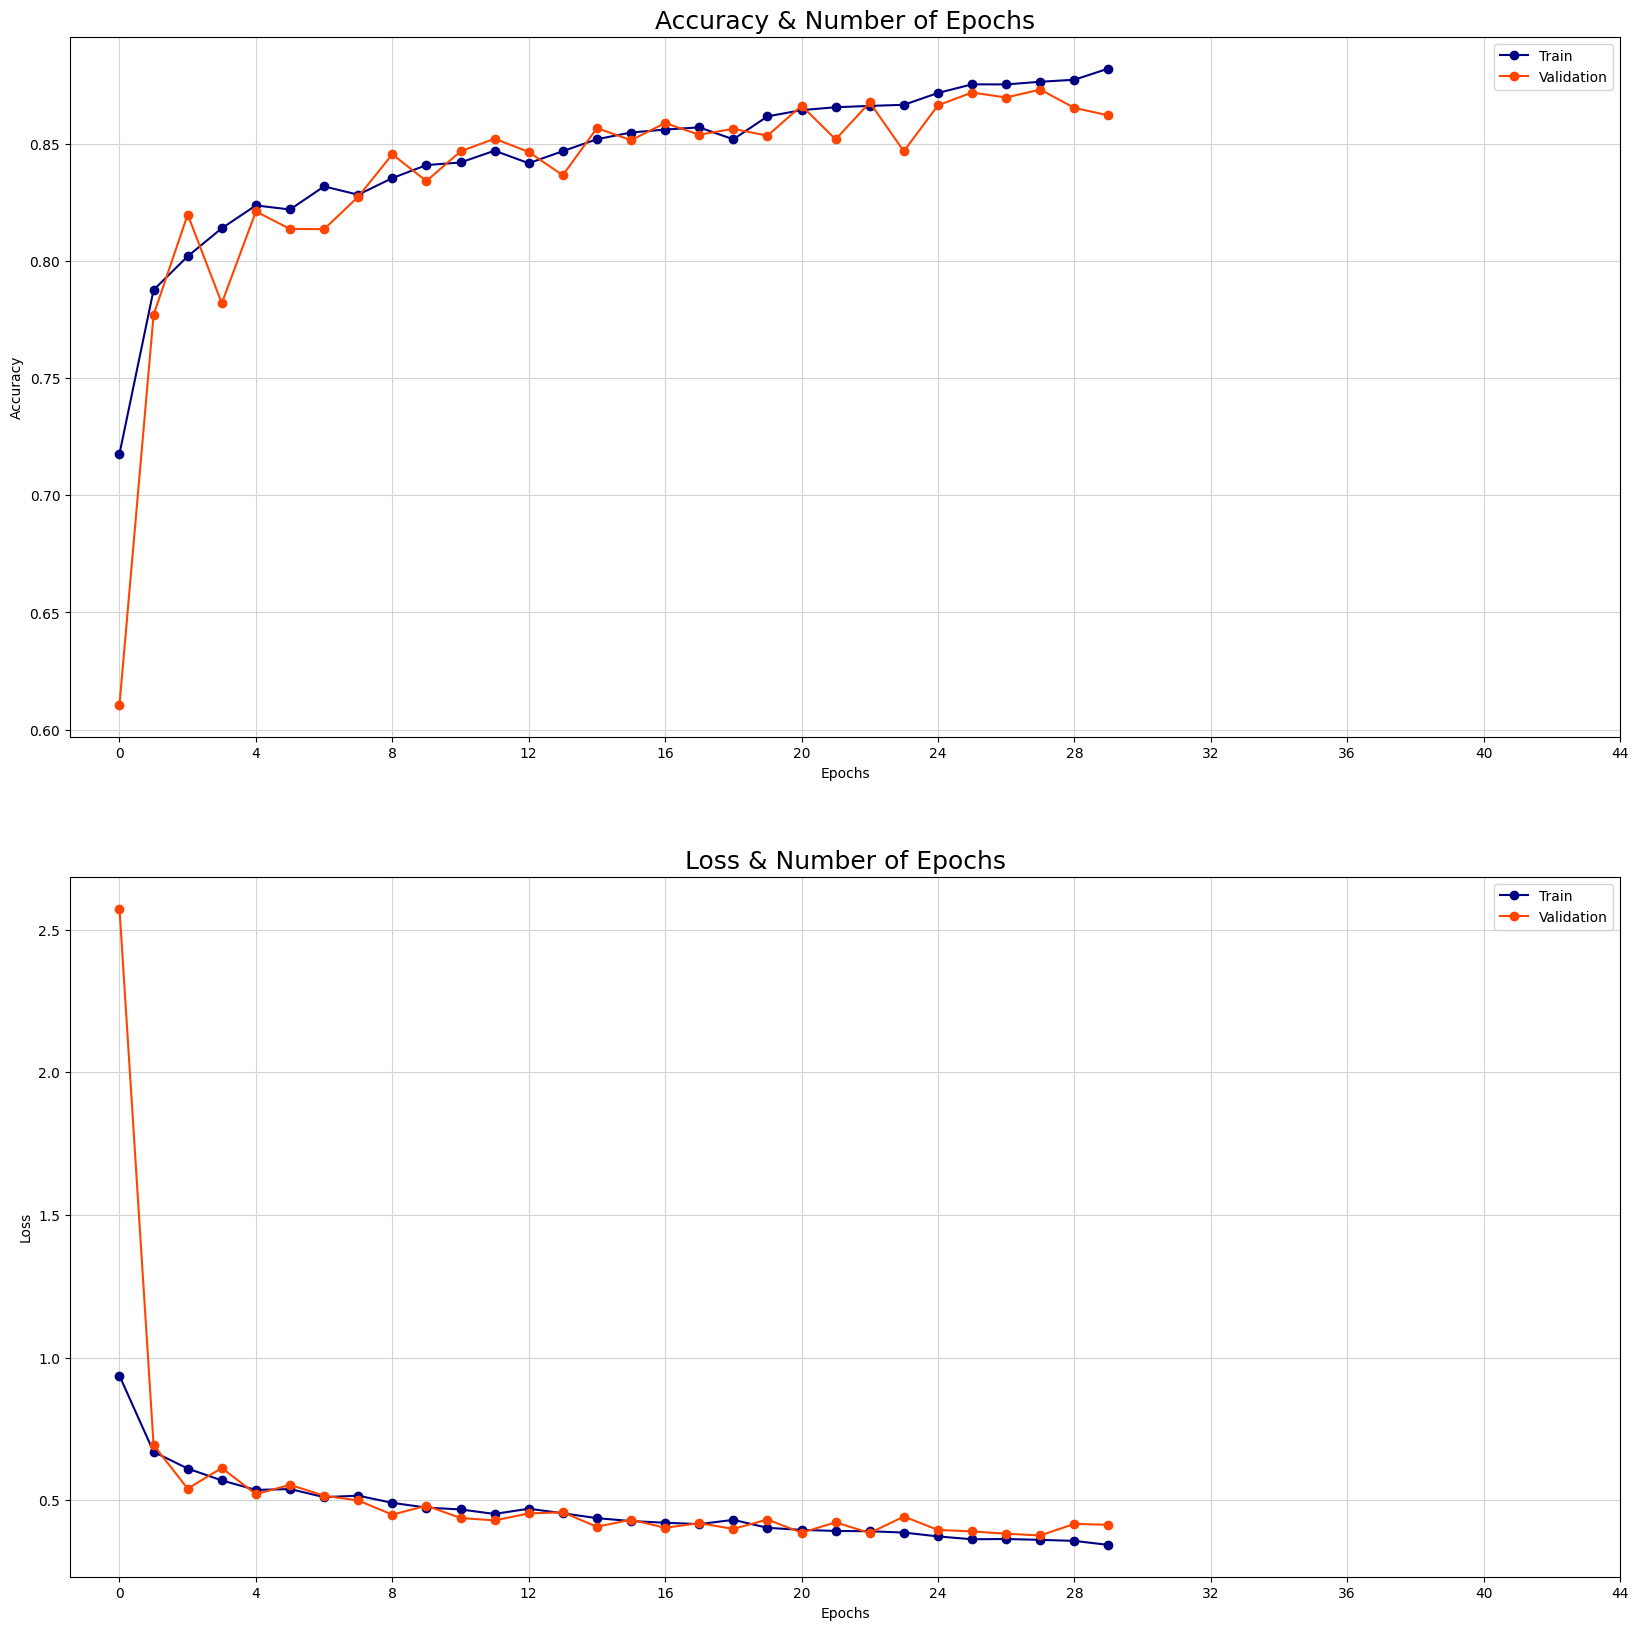

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_VGG19 = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_VGG19.history[met], 'o-',color= 'navy')
    ax[i].plot(history_VGG19.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_VGG19[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_VGG19[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")

In [35]:
y_pred_VGG19=model_VGG19.predict(X_test)

9/9 [==============================] - 1s 49ms/step


In [36]:
model_VGG19.save("./VGG19_Unet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Densenet-121 U-Net Model

In [37]:
# Densenet-121 model

def conv_block_Densenet(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def decoder_block_Densenet(inputs, skip_connection_input, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_connection_input])
    x = conv_block_Densenet(x, num_filters)
    return x

In [38]:
def build_Densenet_unet(input_size,n_classes):
    inputs = layers.Input(input_size)
    Densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

# encoder
    s1 = Densenet.get_layer("input_3").output         # (256 x 256)
    s2 = Densenet.get_layer("conv1/relu").output      # (128 x 128)
    s3 = Densenet.get_layer("pool2_relu").output      # (64 x 64)
    s4 = Densenet.get_layer("pool3_relu").output      # (32 x 32)

    # bridge
    b1 = Densenet.get_layer("pool4_relu").output      # (16 x 16)

    # decoder
    d1 = decoder_block_Densenet(b1, s4, 256)
    d2 = decoder_block_Densenet(d1, s3, 128)
    d3 = decoder_block_Densenet(d2, s2, 64)
    d4 = decoder_block_Densenet(d3, s1, 32)

    # output
    dropout = layers.Dropout(0.3)(d4)
    outputs = layers.Conv2D(n_classes, 1, padding="same", activation="softmax")(dropout)

    model_Densenet = Model(inputs, outputs, name="Densenet-121-UNet")
    return model_Densenet


In [39]:
model_Densenet = build_Densenet_unet((img_size, img_size, num_channels), num_classes)
model_Densenet.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "Densenet-121-UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_3[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchN

In [ ]:
keras.utils.plot_model(
    model_Densenet,
    to_file='Densenet_UNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

Output hidden; open in https://colab.research.google.com to view.

In [40]:
# compile the model
model_Densenet.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

checkpoint_Densenet = ModelCheckpoint("./Densenet_UNet.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping_Densenet = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)
reduce_learningrate_Densenet = ReduceLROnPlateau(monitor='val_acc',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

callbacks_list_Densenet = [early_stopping_Densenet,checkpoint_Densenet,reduce_learningrate_Densenet]

In [41]:
history_Densenet = model_Densenet.fit(X_train, y_train, batch_size = 16, verbose=1, epochs= 30, validation_data=(X_test, y_test), callbacks = callbacks_list_Densenet)

Epoch 1/30
131/131 [==============================] - ETA: 0s - loss: 0.8495 - accuracy: 0.7542

131/131 [==============================] - 73s 175ms/step - loss: 0.8495 - accuracy: 0.7542 - val_loss: 2.2769 - val_accuracy: 0.4107 - lr: 0.0010
Epoch 2/30
131/131 [==============================] - ETA: 0s - loss: 0.6126 - accuracy: 0.8056

131/131 [==============================] - 15s 114ms/step - loss: 0.6126 - accuracy: 0.8056 - val_loss: 1.2206 - val_accuracy: 0.6588 - lr: 0.0010
Epoch 3/30
131/131 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.8225

131/131 [==============================] - 15s 114ms/step - loss: 0.5440 - accuracy: 0.8225 - val_loss: 0.5651 - val_accuracy: 0.7983 - lr: 0.0010
Epoch 4/30
131/131 [==============================] - ETA: 0s - loss: 0.5000 - accuracy: 0.8347

131/131 [==============================] - 15s 114ms/step - loss: 0.5000 - accuracy: 0.8347 - val_loss: 0.5446 - val_accuracy: 0.8101 - lr: 0.0010
Epoch 5/30
131/131 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.8450

131/131 [==============================] - 15s 115ms/step - loss: 0.4708 - accuracy: 0.8450 - val_loss: 0.4895 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 6/30
131/131 [==============================] - ETA: 0s - loss: 0.4470 - accuracy: 0.8506

131/131 [==============================] - 15s 114ms/step - loss: 0.4470 - accuracy: 0.8506 - val_loss: 0.9534 - val_accuracy: 0.7042 - lr: 0.0010
Epoch 7/30
131/131 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8560

131/131 [==============================] - 15s 114ms/step - loss: 0.4298 - accuracy: 0.8560 - val_loss: 0.5158 - val_accuracy: 0.8297 - lr: 0.0010
Epoch 8/30
131/131 [==============================] - ETA: 0s - loss: 0.4272 - accuracy: 0.8566

131/131 [==============================] - 15s 113ms/step - loss: 0.4272 - accuracy: 0.8566 - val_loss: 0.4500 - val_accuracy: 0.8479 - lr: 0.0010
Epoch 9/30
131/131 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.8495

131/131 [==============================] - 15s 115ms/step - loss: 0.4467 - accuracy: 0.8495 - val_loss: 0.7485 - val_accuracy: 0.7191 - lr: 0.0010
Epoch 10/30
131/131 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.8734

131/131 [==============================] - 15s 114ms/step - loss: 0.3784 - accuracy: 0.8734 - val_loss: 0.4533 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 11/30
131/131 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.8809

131/131 [==============================] - 15s 114ms/step - loss: 0.3553 - accuracy: 0.8809 - val_loss: 0.3766 - val_accuracy: 0.8711 - lr: 0.0010
Epoch 12/30
131/131 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8772

131/131 [==============================] - 15s 115ms/step - loss: 0.3647 - accuracy: 0.8772 - val_loss: 0.5275 - val_accuracy: 0.8309 - lr: 0.0010
Epoch 13/30
131/131 [==============================] - ETA: 0s - loss: 0.3476 - accuracy: 0.8819

131/131 [==============================] - 15s 114ms/step - loss: 0.3476 - accuracy: 0.8819 - val_loss: 0.4421 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 14/30
131/131 [==============================] - ETA: 0s - loss: 0.3176 - accuracy: 0.8918

131/131 [==============================] - 15s 115ms/step - loss: 0.3176 - accuracy: 0.8918 - val_loss: 0.4002 - val_accuracy: 0.8691 - lr: 0.0010
Epoch 15/30
131/131 [==============================] - ETA: 0s - loss: 0.3102 - accuracy: 0.8942

131/131 [==============================] - 15s 115ms/step - loss: 0.3102 - accuracy: 0.8942 - val_loss: 0.3873 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 16/30
131/131 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.9067

131/131 [==============================] - 15s 114ms/step - loss: 0.2733 - accuracy: 0.9067 - val_loss: 0.4036 - val_accuracy: 0.8697 - lr: 0.0010
Epoch 17/30
131/131 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.9053

131/131 [==============================] - 15s 114ms/step - loss: 0.2769 - accuracy: 0.9053 - val_loss: 0.4217 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 18/30
131/131 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.9075

131/131 [==============================] - 15s 114ms/step - loss: 0.2687 - accuracy: 0.9075 - val_loss: 0.4537 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 19/30
131/131 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8970

131/131 [==============================] - 15s 114ms/step - loss: 0.3023 - accuracy: 0.8970 - val_loss: 0.4176 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 20/30
131/131 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.9013

131/131 [==============================] - 15s 114ms/step - loss: 0.2881 - accuracy: 0.9013 - val_loss: 0.4196 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 21/30
131/131 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.9151

131/131 [==============================] - 15s 114ms/step - loss: 0.2454 - accuracy: 0.9151 - val_loss: 0.4101 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 22/30
131/131 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9215

131/131 [==============================] - 15s 114ms/step - loss: 0.2259 - accuracy: 0.9215 - val_loss: 0.4098 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 23/30
131/131 [==============================] - ETA: 0s - loss: 0.2176 - accuracy: 0.9239

131/131 [==============================] - 15s 114ms/step - loss: 0.2176 - accuracy: 0.9239 - val_loss: 0.4127 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 24/30
131/131 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9262

131/131 [==============================] - 15s 114ms/step - loss: 0.2078 - accuracy: 0.9262 - val_loss: 0.4389 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 25/30
131/131 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9270

131/131 [==============================] - 15s 114ms/step - loss: 0.2064 - accuracy: 0.9270 - val_loss: 0.3821 - val_accuracy: 0.8829 - lr: 0.0010
Epoch 26/30
131/131 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9301

131/131 [==============================] - 15s 114ms/step - loss: 0.1961 - accuracy: 0.9301 - val_loss: 0.3861 - val_accuracy: 0.8784 - lr: 0.0010
Epoch 27/30
131/131 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9342

131/131 [==============================] - 15s 114ms/step - loss: 0.1833 - accuracy: 0.9342 - val_loss: 0.4149 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 28/30
131/131 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9331

131/131 [==============================] - 15s 114ms/step - loss: 0.1867 - accuracy: 0.9331 - val_loss: 0.3873 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 29/30
131/131 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.9103

131/131 [==============================] - 15s 114ms/step - loss: 0.2572 - accuracy: 0.9103 - val_loss: 0.4288 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 30/30
131/131 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9164

131/131 [==============================] - 15s 114ms/step - loss: 0.2455 - accuracy: 0.9164 - val_loss: 0.3997 - val_accuracy: 0.8793 - lr: 0.0010


In [42]:
df_result_Densenet = pd.DataFrame(history_Densenet.history)
df_result_Densenet

loss  accuracy  val_loss  val_accuracy     lr
0   0.849528  0.754153  2.276880      0.410682  0.001
1   0.612619  0.805622  1.220625      0.658762  0.001
2   0.544034  0.822479  0.565098      0.798340  0.001
3   0.499956  0.834722  0.544555      0.810062  0.001
4   0.470797  0.845024  0.489455      0.829895  0.001
5   0.447015  0.850564  0.953357      0.704191  0.001
6   0.429822  0.855951  0.515798      0.829715  0.001
7   0.427224  0.856586  0.449964      0.847860  0.001
8   0.446712  0.849496  0.748456      0.719103  0.001
9   0.378373  0.873372  0.453325      0.852893  0.001
10  0.355257  0.880886  0.376628      0.871096  0.001
11  0.364659  0.877166  0.527460      0.830866  0.001
12  0.347556  0.881871  0.442131      0.850616  0.001
13  0.317560  0.891765  0.400165      0.869121  0.001
14  0.310195  0.894245  0.387349      0.865738  0.001
15  0.273346  0.906732  0.403621      0.869711  0.001
16  0.276851  0.905279  0.421747      0.860226  0.001
17  0.268739  0.907521  0.453738      0.859791  0.001
18  0.302278  0.897019  0.417604      0.864852  0.001
19  0.288122  0.901324  0.419567      0.868431  0.001
20  0.245375  0.915134  0.410129      0.871473  0.001
21  0.225881  0.921470  0.409750      0.879227  0.001
22  0.217613  0.923869  0.412651      0.878663  0.001
23  0.207837  0.926224  0.438883      0.871305  0.001
24  0.206438  0.927040  0.382071      0.882877  0.001
25  0.196111  0.930079  0.386086      0.878363  0.001
26  0.183257  0.934200  0.414869      0.878133  0.001
27  0.186706  0.933062  0.387299      0.884198  0.001
28  0.257193  0.910261  0.428838      0.876962  0.001
29  0.245474  0.916412  0.399704      0.879342  0.001

In [43]:
# evalute model
loss_Densenet,acc_Densenet= model_Densenet.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc_Densenet)

9/9 [==============================] - 3s 54ms/step - loss: 0.3997 - accuracy: 0.8793
accuracy: 0.8793402910232544


<Axes: >

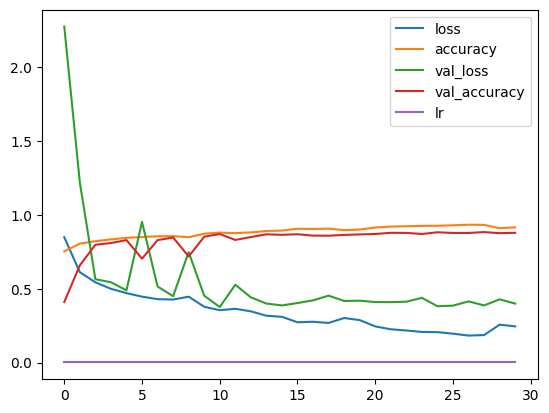

In [44]:
pd.DataFrame(history_Densenet.history).plot()

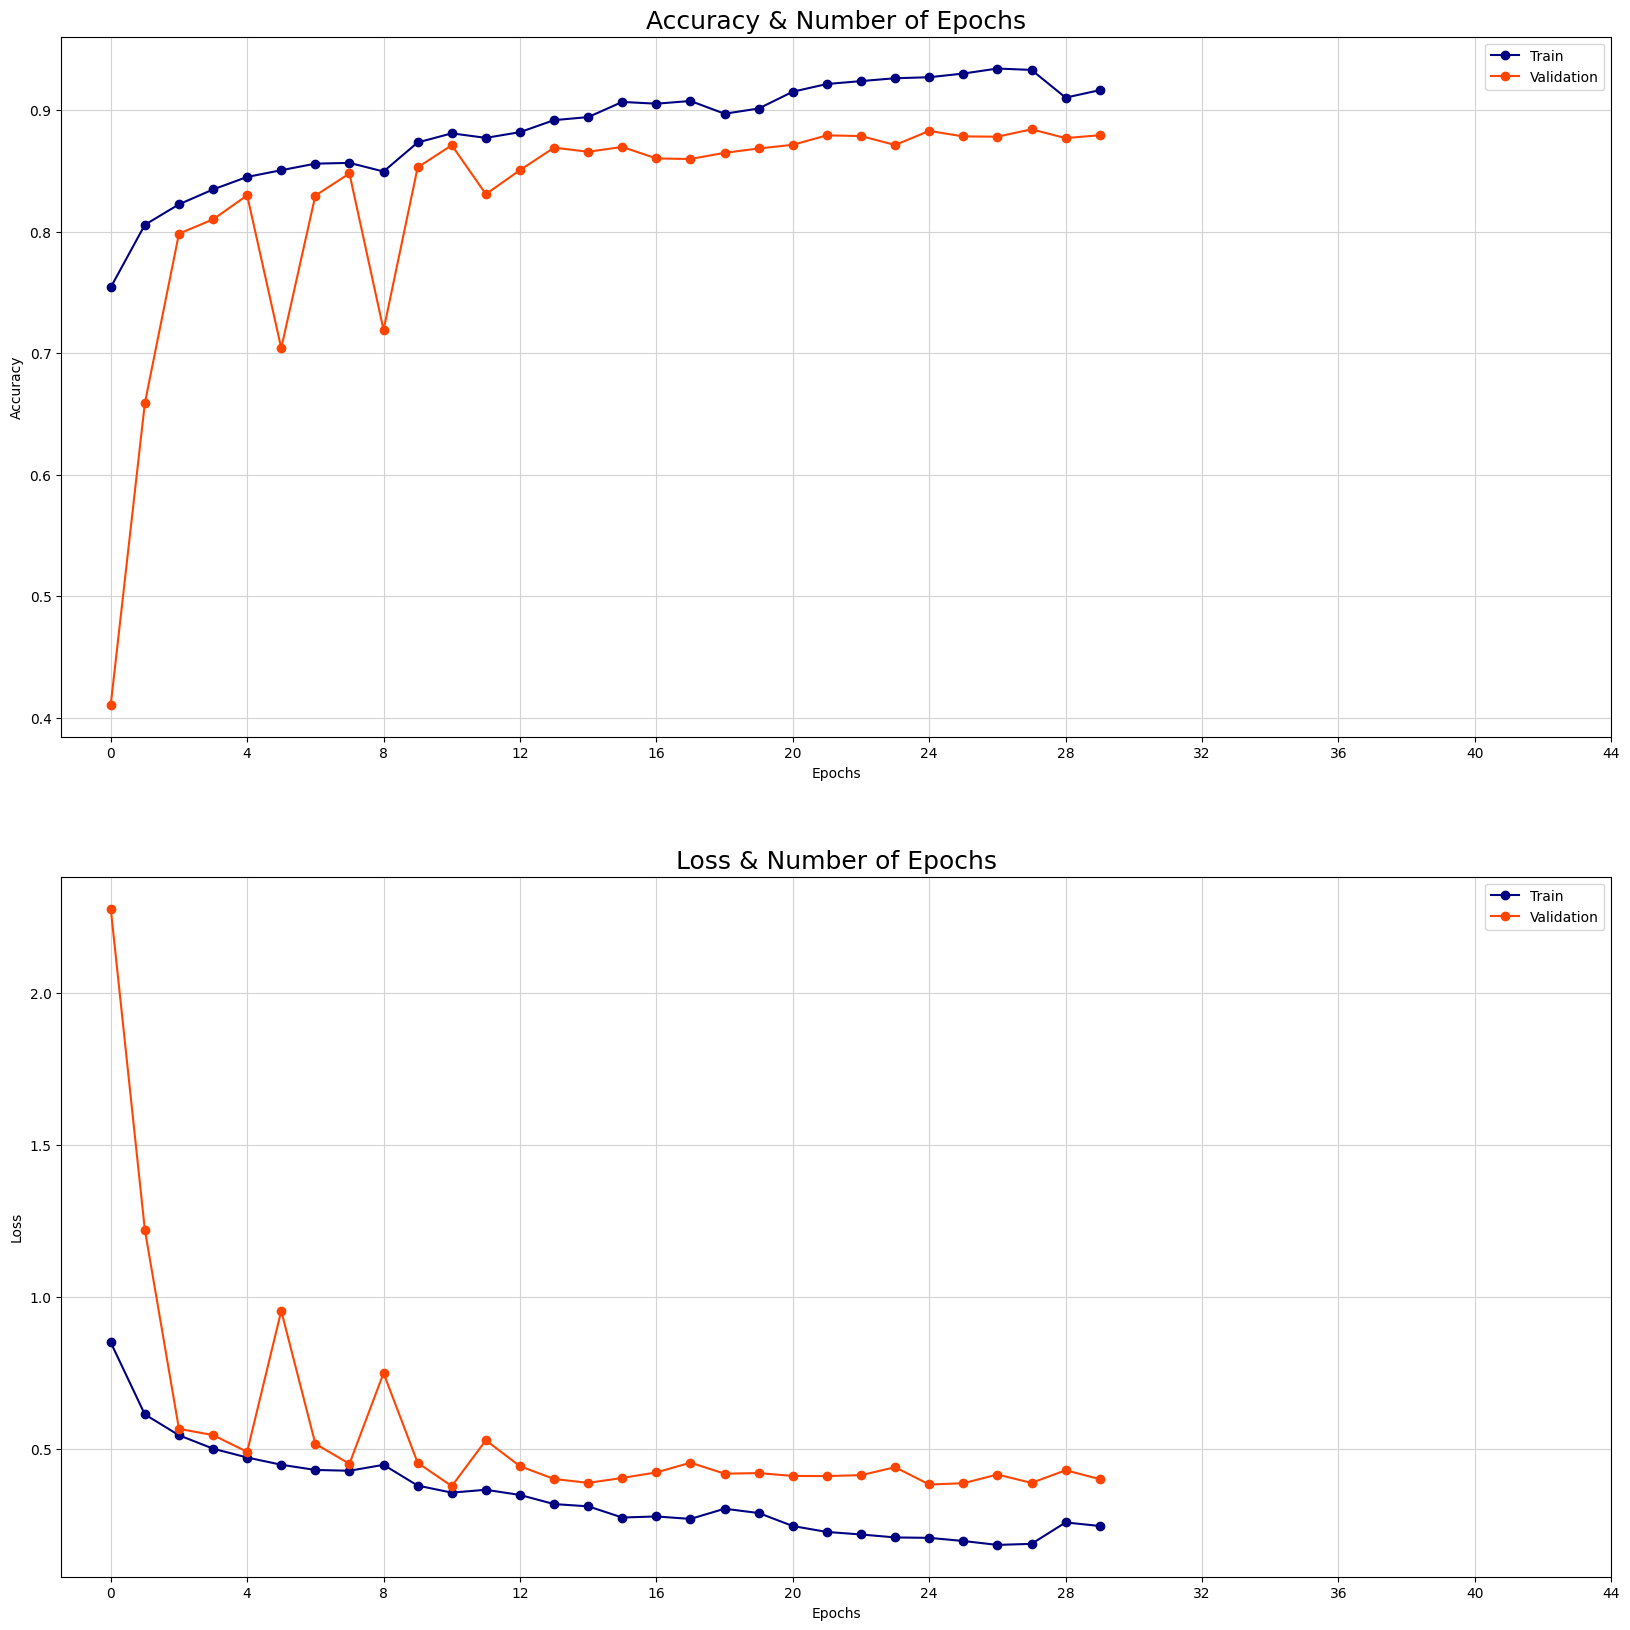

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_Densenet = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_Densenet.history[met], 'o-',color= 'navy')
    ax[i].plot(history_Densenet.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_Densenet[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_Densenet[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")

In [46]:
y_pred_Densenet=model_Densenet.predict(X_test)

9/9 [==============================] - 2s 46ms/step


In [47]:
model_Densenet.save("Densenet_Unet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Attention U-Net

In [48]:
# Attention U-net Model
def conv_block_Attention_unet(x, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder_block_Attention_unet(x, num_filters):
    x = conv_block_Attention_unet(x, num_filters)
    p = layers.MaxPool2D((2, 2))(x)
    return x, p

In [49]:
def attention_gate(g, s, num_filters):
    Wg = layers.Conv2D(num_filters, 1, padding="same")(g)
    Wg = layers.BatchNormalization()(Wg)

    Ws = layers.Conv2D(num_filters, 1, padding="same")(s)
    Ws = layers.BatchNormalization()(Ws)

    out = layers.Activation("relu")(Wg + Ws)
    out = layers.Conv2D(num_filters, 1, padding="same")(out)
    out = layers.Activation("sigmoid")(out)

    return out * s

In [50]:
def decoder_block_Attention_unet(x, s, num_filters):
    x = layers.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = layers.Concatenate()([x, s])
    x = conv_block_Attention_unet(x, num_filters)
    return x

In [51]:
def attention_unet(input_size,n_classes):
    inputs = layers.Input(input_size)

    s1, p1 = encoder_block_Attention_unet(inputs, 64)
    s2, p2 = encoder_block_Attention_unet(p1, 128)
    s3, p3 = encoder_block_Attention_unet(p2, 256)

    b1 = conv_block_Attention_unet(p3, 512)

    d1 = decoder_block_Attention_unet(b1, s3, 256)
    d2 = decoder_block_Attention_unet(d1, s2, 128)
    d3 = decoder_block_Attention_unet(d2, s1, 64)

    outputs = layers.Conv2D(filters = n_classes, kernel_size = (1,1), padding="same", activation="softmax")(d3)
    Attention_unet_model = Model(inputs, outputs, name="Attention-UNET")
    return Attention_unet_model

In [52]:
Attention_unet_model = attention_unet((img_size, img_size, num_channels), num_classes)
Attention_unet_model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_34 (Ba  (None, 256, 256, 64)         256       ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_34 (Activation)  (None, 256, 256, 64)         0         ['batch_normaliza

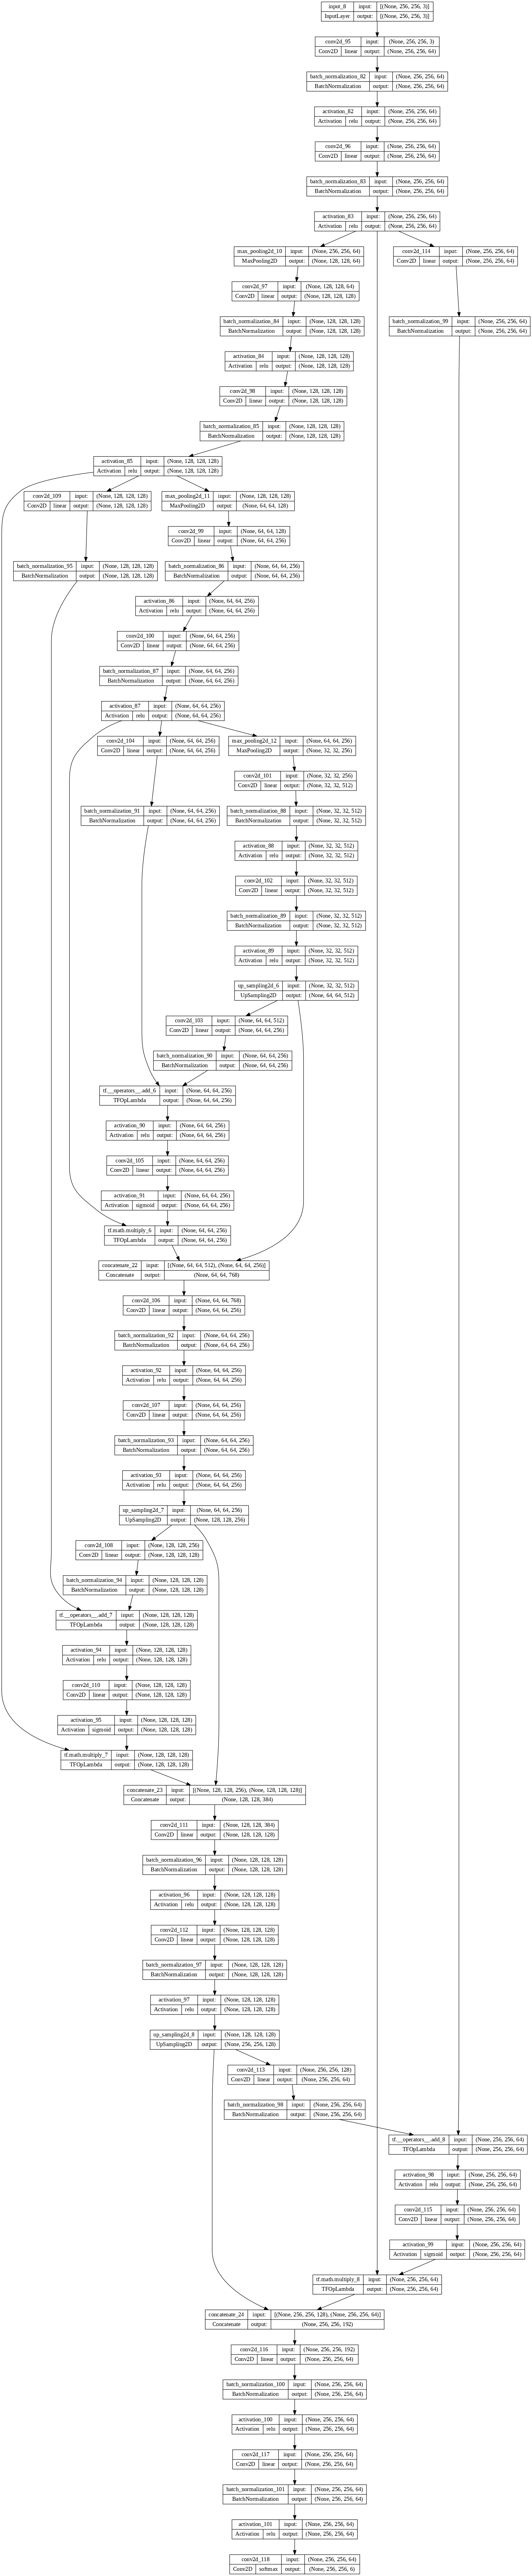

In [ ]:
keras.utils.plot_model(
    Attention_unet_model,
    to_file='Attention_UNet_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [53]:
# compile the model
Attention_unet_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

checkpoint_Attention_unet = ModelCheckpoint("./Attention_UNet.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping_Attention_unet = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)
reduce_learningrate_Attention_unet = ReduceLROnPlateau(monitor='val_acc',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

callbacks_list_Attention_unet = [early_stopping_Attention_unet,checkpoint_Attention_unet,reduce_learningrate_Attention_unet]

In [54]:
history_Attention_unet = Attention_unet_model.fit(X_train, y_train, batch_size = 16, verbose=1, epochs= 30, validation_data=(X_test, y_test), callbacks = callbacks_list_Attention_unet)

Epoch 1/30
131/131 [==============================] - ETA: 0s - loss: 0.8207 - accuracy: 0.7197

131/131 [==============================] - 59s 278ms/step - loss: 0.8207 - accuracy: 0.7197 - val_loss: 1.7002 - val_accuracy: 0.5077 - lr: 0.0010
Epoch 2/30
131/131 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.7705

131/131 [==============================] - 21s 161ms/step - loss: 0.6666 - accuracy: 0.7705 - val_loss: 1.4597 - val_accuracy: 0.5484 - lr: 0.0010
Epoch 3/30
131/131 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.7810

131/131 [==============================] - 21s 160ms/step - loss: 0.6323 - accuracy: 0.7810 - val_loss: 1.6078 - val_accuracy: 0.6057 - lr: 0.0010
Epoch 4/30
131/131 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.7968

131/131 [==============================] - 21s 160ms/step - loss: 0.5871 - accuracy: 0.7968 - val_loss: 0.7931 - val_accuracy: 0.7108 - lr: 0.0010
Epoch 5/30
131/131 [==============================] - ETA: 0s - loss: 0.5725 - accuracy: 0.8051

131/131 [==============================] - 21s 161ms/step - loss: 0.5725 - accuracy: 0.8051 - val_loss: 0.6890 - val_accuracy: 0.7631 - lr: 0.0010
Epoch 6/30
131/131 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.8197

131/131 [==============================] - 21s 160ms/step - loss: 0.5294 - accuracy: 0.8197 - val_loss: 0.5760 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 7/30
131/131 [==============================] - ETA: 0s - loss: 0.5131 - accuracy: 0.8244

131/131 [==============================] - 21s 160ms/step - loss: 0.5131 - accuracy: 0.8244 - val_loss: 0.5068 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 8/30
131/131 [==============================] - ETA: 0s - loss: 0.5162 - accuracy: 0.8227

131/131 [==============================] - 21s 160ms/step - loss: 0.5162 - accuracy: 0.8227 - val_loss: 0.7418 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 9/30
131/131 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.8310

131/131 [==============================] - 21s 161ms/step - loss: 0.4918 - accuracy: 0.8310 - val_loss: 0.9217 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 10/30
131/131 [==============================] - ETA: 0s - loss: 0.4827 - accuracy: 0.8337

131/131 [==============================] - 21s 161ms/step - loss: 0.4827 - accuracy: 0.8337 - val_loss: 0.5585 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 11/30
131/131 [==============================] - ETA: 0s - loss: 0.4731 - accuracy: 0.8354

131/131 [==============================] - 21s 160ms/step - loss: 0.4731 - accuracy: 0.8354 - val_loss: 0.4956 - val_accuracy: 0.8276 - lr: 0.0010
Epoch 12/30
131/131 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.8365

131/131 [==============================] - 21s 160ms/step - loss: 0.4688 - accuracy: 0.8365 - val_loss: 0.5196 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 13/30
131/131 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.8424

131/131 [==============================] - 21s 160ms/step - loss: 0.4509 - accuracy: 0.8424 - val_loss: 0.7334 - val_accuracy: 0.7168 - lr: 0.0010
Epoch 14/30
131/131 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.8477

131/131 [==============================] - 21s 160ms/step - loss: 0.4354 - accuracy: 0.8477 - val_loss: 0.4781 - val_accuracy: 0.8313 - lr: 0.0010
Epoch 15/30
131/131 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.8446

131/131 [==============================] - 21s 160ms/step - loss: 0.4436 - accuracy: 0.8446 - val_loss: 0.4639 - val_accuracy: 0.8407 - lr: 0.0010
Epoch 16/30
131/131 [==============================] - ETA: 0s - loss: 0.4351 - accuracy: 0.8468

131/131 [==============================] - 21s 160ms/step - loss: 0.4351 - accuracy: 0.8468 - val_loss: 0.5937 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 17/30
131/131 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.8494

131/131 [==============================] - 21s 160ms/step - loss: 0.4285 - accuracy: 0.8494 - val_loss: 0.4067 - val_accuracy: 0.8616 - lr: 0.0010
Epoch 18/30
131/131 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.8495

131/131 [==============================] - 21s 160ms/step - loss: 0.4263 - accuracy: 0.8495 - val_loss: 0.4191 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 19/30
131/131 [==============================] - ETA: 0s - loss: 0.4126 - accuracy: 0.8537

131/131 [==============================] - 21s 160ms/step - loss: 0.4126 - accuracy: 0.8537 - val_loss: 0.5075 - val_accuracy: 0.8297 - lr: 0.0010
Epoch 20/30
131/131 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.8571

131/131 [==============================] - 21s 160ms/step - loss: 0.4019 - accuracy: 0.8571 - val_loss: 0.4380 - val_accuracy: 0.8457 - lr: 0.0010
Epoch 21/30
131/131 [==============================] - ETA: 0s - loss: 0.3972 - accuracy: 0.8584

131/131 [==============================] - 21s 160ms/step - loss: 0.3972 - accuracy: 0.8584 - val_loss: 0.4287 - val_accuracy: 0.8511 - lr: 0.0010
Epoch 22/30
131/131 [==============================] - ETA: 0s - loss: 0.3966 - accuracy: 0.8590

131/131 [==============================] - 21s 160ms/step - loss: 0.3966 - accuracy: 0.8590 - val_loss: 0.4412 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 23/30
131/131 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.8600

131/131 [==============================] - 21s 160ms/step - loss: 0.3903 - accuracy: 0.8600 - val_loss: 0.4103 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 24/30
131/131 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8623

131/131 [==============================] - 21s 160ms/step - loss: 0.3823 - accuracy: 0.8623 - val_loss: 0.5221 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 25/30
131/131 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.8642

131/131 [==============================] - 21s 160ms/step - loss: 0.3776 - accuracy: 0.8642 - val_loss: 0.4090 - val_accuracy: 0.8606 - lr: 0.0010
Epoch 26/30
131/131 [==============================] - ETA: 0s - loss: 0.3798 - accuracy: 0.8632

131/131 [==============================] - 21s 160ms/step - loss: 0.3798 - accuracy: 0.8632 - val_loss: 0.4414 - val_accuracy: 0.8489 - lr: 0.0010
Epoch 27/30
131/131 [==============================] - ETA: 0s - loss: 0.3798 - accuracy: 0.8644

131/131 [==============================] - 21s 161ms/step - loss: 0.3798 - accuracy: 0.8644 - val_loss: 0.6315 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 28/30
131/131 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.8641

131/131 [==============================] - 21s 161ms/step - loss: 0.3793 - accuracy: 0.8641 - val_loss: 0.4049 - val_accuracy: 0.8524 - lr: 0.0010
Epoch 29/30
131/131 [==============================] - ETA: 0s - loss: 0.3605 - accuracy: 0.8692

131/131 [==============================] - 21s 161ms/step - loss: 0.3605 - accuracy: 0.8692 - val_loss: 0.4628 - val_accuracy: 0.8501 - lr: 0.0010
Epoch 30/30
131/131 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.8682

131/131 [==============================] - 21s 160ms/step - loss: 0.3654 - accuracy: 0.8682 - val_loss: 0.4193 - val_accuracy: 0.8509 - lr: 0.0010


In [55]:
df_Attention_unet = pd.DataFrame(history_Attention_unet.history)
df_Attention_unet

loss  accuracy  val_loss  val_accuracy     lr
0   0.820667  0.719721  1.700246      0.507701  0.001
1   0.666620  0.770540  1.459721      0.548447  0.001
2   0.632346  0.781017  1.607833      0.605726  0.001
3   0.587086  0.796798  0.793128      0.710770  0.001
4   0.572458  0.805056  0.689024      0.763073  0.001
5   0.529414  0.819689  0.575953      0.817694  0.001
6   0.513126  0.824427  0.506815      0.825940  0.001
7   0.516208  0.822678  0.741780      0.714023  0.001
8   0.491767  0.830997  0.921749      0.752378  0.001
9   0.482684  0.833652  0.558539      0.793307  0.001
10  0.473111  0.835366  0.495619      0.827588  0.001
11  0.468790  0.836509  0.519648      0.817084  0.001
12  0.450931  0.842373  0.733363      0.716804  0.001
13  0.435385  0.847685  0.478068      0.831341  0.001
14  0.443567  0.844616  0.463898      0.840749  0.001
15  0.435053  0.846766  0.593652      0.804910  0.001
16  0.428509  0.849401  0.406743      0.861564  0.001
17  0.426265  0.849476  0.419120      0.855668  0.001
18  0.412614  0.853746  0.507455      0.829696  0.001
19  0.401896  0.857065  0.437980      0.845652  0.001
20  0.397196  0.858418  0.428653      0.851064  0.001
21  0.396620  0.858955  0.441158      0.844433  0.001
22  0.390307  0.860001  0.410345      0.857701  0.001
23  0.382329  0.862335  0.522140      0.819550  0.001
24  0.377557  0.864201  0.409009      0.860585  0.001
25  0.379816  0.863243  0.441446      0.848911  0.001
26  0.379758  0.864434  0.631539      0.780951  0.001
27  0.379323  0.864072  0.404948      0.852407  0.001
28  0.360474  0.869157  0.462814      0.850065  0.001
29  0.365394  0.868224  0.419300      0.850940  0.001

In [56]:
# evalute model
loss_Attention_unet,acc_Attention_unet= Attention_unet_model.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc_Attention_unet)

9/9 [==============================] - 12s 90ms/step - loss: 0.4193 - accuracy: 0.8509
accuracy: 0.8509402275085449


<Axes: >

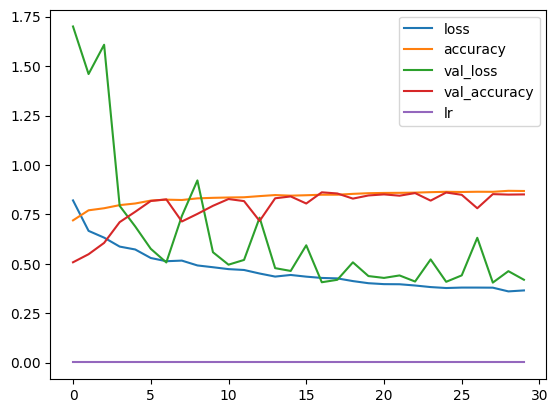

In [57]:
pd.DataFrame(history_Attention_unet.history).plot()

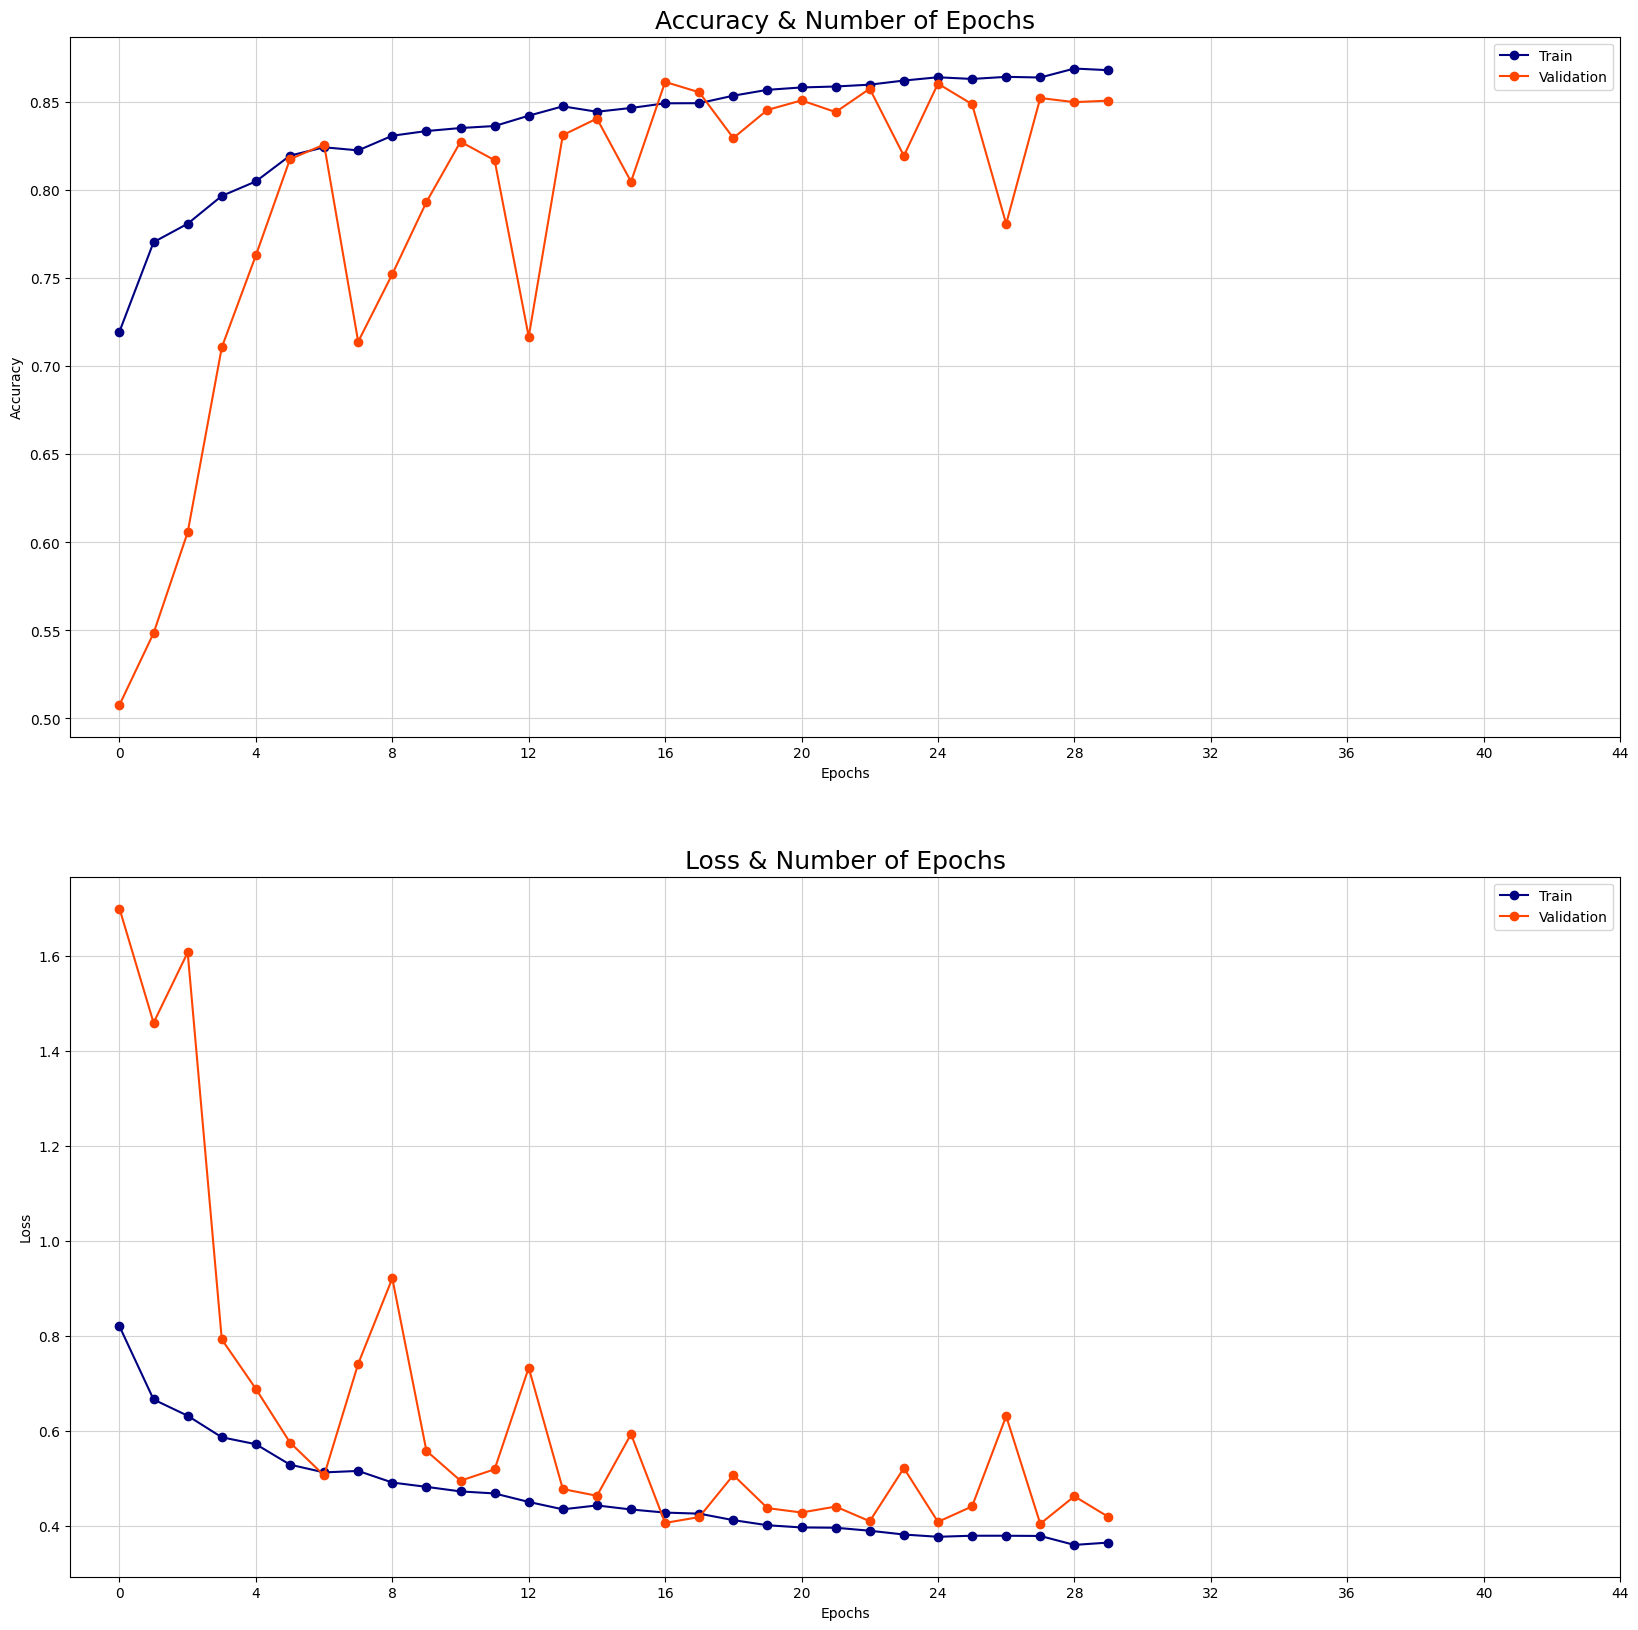

In [58]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_Attention_unet = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_Attention_unet.history[met], 'o-',color= 'navy')
    ax[i].plot(history_Attention_unet.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_Attention_unet[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_Attention_unet[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")



In [59]:
y_pred_Attention_unet=Attention_unet_model.predict(X_test)

9/9 [==============================] - 1s 87ms/step


In [60]:
Attention_unet_model.save("Attention_Unet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## UNETR

In [68]:
# cutting up 256X256 images into 16X16 patches for fedding them into the Tranformers encoder
x_train =[]
x_test =[]

for img in X_train:
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size)  # (16, 16, 1, 16, 16, 3)
    rs_patches = np.reshape(patches, flat_patches_shape)
    # rs_patches = rs_patches.astype(np.float32)
    x_train.append(rs_patches)

for img in X_test:
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size) # (16, 16, 1, 16, 16, 3)
    rs_patches = np.reshape(patches, flat_patches_shape)
    # rs_patches = rs_patches.astype(np.float32)
    x_test.append(rs_patches)

x_train = np.array(x_train)
x_test = np.array(x_test)
print('Transformers x_train shape: ', x_train.shape)
print('Transformers x_test shape: ', x_test.shape)

Transformers x_train shape:  (2088, 256, 768)
Transformers x_test shape:  (261, 256, 768)


In [69]:
# UNETR model => Transformer ecoder (as backbone to leran the global contexual representation) & CNN-based decoder (to upsample the global representation and generate the final segmentation mask)
# encoder
def mlp(x, mlp_dim, hidden_dim, dropout_rate):
    x = layers.Dense(mlp_dim, activation="gelu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(hidden_dim)(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def vit_encoder(x, num_heads, hidden_dim):
    # Layer normalization 1
    x1 = layers.LayerNormalization()(x)
    # multi-head attention layer
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim, dropout=0.1)(x1, x1)
    # Skip connection 1
    x2 = layers.Add()([attention_output, x])
    # Layer normalization 2
    x3 = layers.LayerNormalization()(x2)
    # MLP
    x3 = mlp(x3, mlp_dim, hidden_dim, dropout_rate)
    x = layers.Add()([x3, x2])
    return x

# decoder
def conv_block(x, num_filters):
    x = layers.Conv2D(num_filters, kernel_size=3, padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def deconv_block(x, num_filters):
    x = layers.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x

In [70]:
def UNETR_2D():
    input_shape = (num_patches, patch_size*patch_size*num_channels)
    inputs = layers.Input(input_shape)

    # Patch & Position Embeddings ----------------------------------------------------------------------
    patch_embed = layers.Dense(hidden_dim)(inputs)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positions_embed = layers.Embedding(input_dim=num_patches, output_dim=hidden_dim)(positions)
    x = patch_embed + positions_embed

    # Transformer Encoder ------------------------------------------------------------------------------
    skip_connection_index = [3, 6, 9, 12] # the number of transformers layers in which there are skip conncetions based on the original paper (z3, z6,z9,z12)
    skip_connections = [] # svae the outputs of transformers layers in which there are skip conncetions

    # 12 layers of the Transformer block
    for i in range(1, transformer_layers+1, 1):
        x = vit_encoder(x, num_heads, hidden_dim)
        if i in skip_connection_index:
            skip_connections.append(x)

    # CNN Decoder ---------------------------------------------------------------------------------------
    z3, z6, z9, z12 = skip_connections

    # reshape the transformers outputs to pass to the CNN decoder (skip connections)
    z0 = layers.Reshape((img_size, img_size, num_channels))(inputs)
    shape = (img_size//patch_size,img_size//patch_size,hidden_dim)
    z3 = layers.Reshape(shape)(z3)
    z6 = layers.Reshape(shape)(z6)
    z9 = layers.Reshape(shape)(z9)
    z12 = layers.Reshape(shape)(z12)

    ## Decoder 1--------------
    x = deconv_block(z12, 512)

    s = deconv_block(z9, 512)
    s = conv_block(s, 512)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 512)
    x = conv_block(x, 512)

    ## Decoder 2--------------
    x = deconv_block(x, 256)

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)
    s = deconv_block(s, 256)
    s = conv_block(s, 256)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    ## Decoder 3--------------
    x = deconv_block(x, 128)

    s = deconv_block(z3, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 4--------------
    x = deconv_block(x, 64)

    s = conv_block(z0, 64)
    s = conv_block(s, 64)

    x = layers.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    outputs = layers.Conv2D(num_classes, kernel_size=1, padding="same", activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [71]:
UNETR_model = UNETR_2D()
UNETR_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 768)]           0         []                            
                                                                                                  
 dense (Dense)               (None, 256, 768)             590592    ['input_5[0][0]']             
                                                                                                  
 tf.__operators__.add_3 (TF  (None, 256, 768)             0         ['dense[0][0]']               
 OpLambda)                                                                                        
                                                                                                  
 layer_normalization (Layer  (None, 256, 768)             1536      ['tf.__operators__.add_3

In [ ]:
keras.utils.plot_model(
    UNETR_model,
    to_file='UNETR_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

Output hidden; open in https://colab.research.google.com to view.

In [72]:
UNETR_model.compile(optimizer=Adam(lr=0.0001), loss = "categorical_crossentropy" , metrics = ['accuracy'])

UNETR_checkpoint = ModelCheckpoint("./UNETR.weights.h5",monitor='val_acc', verbose=1, save_best_only=True, mode='max')
UNETR_early_stopping = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)
UNETR_reduce_learningrate = ReduceLROnPlateau(monitor='val_acc',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
UNETR_callbacks_list = [UNETR_early_stopping,UNETR_checkpoint,UNETR_reduce_learningrate]

In [73]:
history_UNETR = UNETR_model.fit(x_train, y_train, batch_size = 16, verbose=1, epochs= 30, validation_data=(x_test, y_test), callbacks = UNETR_callbacks_list, shuffle=True)

Epoch 1/30
131/131 [==============================] - ETA: 0s - loss: 1.1064 - accuracy: 0.6218

131/131 [==============================] - 210s 1s/step - loss: 1.1064 - accuracy: 0.6218 - val_loss: 304.4799 - val_accuracy: 0.1183 - lr: 0.0010
Epoch 2/30
131/131 [==============================] - ETA: 0s - loss: 0.9417 - accuracy: 0.6558

131/131 [==============================] - 114s 872ms/step - loss: 0.9417 - accuracy: 0.6558 - val_loss: 5.0317 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 3/30
131/131 [==============================] - ETA: 0s - loss: 0.9085 - accuracy: 0.6635

131/131 [==============================] - 114s 872ms/step - loss: 0.9085 - accuracy: 0.6635 - val_loss: 12.7525 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 4/30
131/131 [==============================] - ETA: 0s - loss: 0.8897 - accuracy: 0.6732

131/131 [==============================] - 114s 872ms/step - loss: 0.8897 - accuracy: 0.6732 - val_loss: 5.9653 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 5/30
131/131 [==============================] - ETA: 0s - loss: 0.8890 - accuracy: 0.6737

131/131 [==============================] - 114s 872ms/step - loss: 0.8890 - accuracy: 0.6737 - val_loss: 1.5104 - val_accuracy: 0.3625 - lr: 0.0010
Epoch 6/30
131/131 [==============================] - ETA: 0s - loss: 0.8620 - accuracy: 0.6816

131/131 [==============================] - 114s 873ms/step - loss: 0.8620 - accuracy: 0.6816 - val_loss: 2.0430 - val_accuracy: 0.2381 - lr: 0.0010
Epoch 7/30
131/131 [==============================] - ETA: 0s - loss: 0.8370 - accuracy: 0.6923

131/131 [==============================] - 114s 873ms/step - loss: 0.8370 - accuracy: 0.6923 - val_loss: 1.1206 - val_accuracy: 0.6173 - lr: 0.0010
Epoch 8/30
131/131 [==============================] - ETA: 0s - loss: 0.8903 - accuracy: 0.6747

131/131 [==============================] - 114s 873ms/step - loss: 0.8903 - accuracy: 0.6747 - val_loss: 1.0235 - val_accuracy: 0.6064 - lr: 0.0010
Epoch 9/30
131/131 [==============================] - ETA: 0s - loss: 0.8501 - accuracy: 0.6889

131/131 [==============================] - 114s 873ms/step - loss: 0.8501 - accuracy: 0.6889 - val_loss: 1.1455 - val_accuracy: 0.5290 - lr: 0.0010
Epoch 10/30
131/131 [==============================] - ETA: 0s - loss: 0.8466 - accuracy: 0.6911

131/131 [==============================] - 114s 873ms/step - loss: 0.8466 - accuracy: 0.6911 - val_loss: 1.0401 - val_accuracy: 0.6347 - lr: 0.0010
Epoch 11/30
131/131 [==============================] - ETA: 0s - loss: 0.8389 - accuracy: 0.6933

131/131 [==============================] - 114s 872ms/step - loss: 0.8389 - accuracy: 0.6933 - val_loss: 1.0421 - val_accuracy: 0.6228 - lr: 0.0010
Epoch 12/30
131/131 [==============================] - ETA: 0s - loss: 0.8339 - accuracy: 0.6943

131/131 [==============================] - 114s 872ms/step - loss: 0.8339 - accuracy: 0.6943 - val_loss: 1.3248 - val_accuracy: 0.5650 - lr: 0.0010
Epoch 13/30
131/131 [==============================] - ETA: 0s - loss: 0.8224 - accuracy: 0.6988

131/131 [==============================] - 114s 872ms/step - loss: 0.8224 - accuracy: 0.6988 - val_loss: 2.4623 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 14/30
131/131 [==============================] - ETA: 0s - loss: 0.8161 - accuracy: 0.6999

131/131 [==============================] - 114s 872ms/step - loss: 0.8161 - accuracy: 0.6999 - val_loss: 1.2743 - val_accuracy: 0.5640 - lr: 0.0010
Epoch 15/30
131/131 [==============================] - ETA: 0s - loss: 0.8184 - accuracy: 0.6998

131/131 [==============================] - 114s 872ms/step - loss: 0.8184 - accuracy: 0.6998 - val_loss: 1.4038 - val_accuracy: 0.4679 - lr: 0.0010
Epoch 16/30
131/131 [==============================] - ETA: 0s - loss: 0.8444 - accuracy: 0.6922

131/131 [==============================] - 114s 872ms/step - loss: 0.8444 - accuracy: 0.6922 - val_loss: 1.8480 - val_accuracy: 0.2230 - lr: 0.0010
Epoch 17/30
131/131 [==============================] - ETA: 0s - loss: 0.8507 - accuracy: 0.6904

131/131 [==============================] - 114s 872ms/step - loss: 0.8507 - accuracy: 0.6904 - val_loss: 1.2908 - val_accuracy: 0.5844 - lr: 0.0010
Epoch 18/30
131/131 [==============================] - ETA: 0s - loss: 0.8478 - accuracy: 0.6884

131/131 [==============================] - 114s 873ms/step - loss: 0.8478 - accuracy: 0.6884 - val_loss: 1.1025 - val_accuracy: 0.5591 - lr: 0.0010
Epoch 19/30
131/131 [==============================] - ETA: 0s - loss: 0.8285 - accuracy: 0.6955

131/131 [==============================] - 114s 873ms/step - loss: 0.8285 - accuracy: 0.6955 - val_loss: 3.7555 - val_accuracy: 0.1357 - lr: 0.0010
Epoch 20/30
131/131 [==============================] - ETA: 0s - loss: 0.8326 - accuracy: 0.6962

131/131 [==============================] - 114s 873ms/step - loss: 0.8326 - accuracy: 0.6962 - val_loss: 1.0701 - val_accuracy: 0.5855 - lr: 0.0010
Epoch 21/30
131/131 [==============================] - ETA: 0s - loss: 0.8316 - accuracy: 0.6954

131/131 [==============================] - 114s 873ms/step - loss: 0.8316 - accuracy: 0.6954 - val_loss: 1.2964 - val_accuracy: 0.5476 - lr: 0.0010
Epoch 22/30
131/131 [==============================] - ETA: 0s - loss: 0.8508 - accuracy: 0.6887

131/131 [==============================] - 114s 873ms/step - loss: 0.8508 - accuracy: 0.6887 - val_loss: 1.2112 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 23/30
131/131 [==============================] - ETA: 0s - loss: 0.8420 - accuracy: 0.6911

131/131 [==============================] - 114s 872ms/step - loss: 0.8420 - accuracy: 0.6911 - val_loss: 0.9579 - val_accuracy: 0.6336 - lr: 0.0010
Epoch 24/30
131/131 [==============================] - ETA: 0s - loss: 0.8425 - accuracy: 0.6918

131/131 [==============================] - 114s 872ms/step - loss: 0.8425 - accuracy: 0.6918 - val_loss: 1.7761 - val_accuracy: 0.2498 - lr: 0.0010
Epoch 25/30
131/131 [==============================] - ETA: 0s - loss: 0.8425 - accuracy: 0.6927

131/131 [==============================] - 114s 873ms/step - loss: 0.8425 - accuracy: 0.6927 - val_loss: 0.9897 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 26/30
131/131 [==============================] - ETA: 0s - loss: 0.8407 - accuracy: 0.6920

131/131 [==============================] - 114s 873ms/step - loss: 0.8407 - accuracy: 0.6920 - val_loss: 2.5062 - val_accuracy: 0.1303 - lr: 0.0010
Epoch 27/30
131/131 [==============================] - ETA: 0s - loss: 0.8333 - accuracy: 0.6947

131/131 [==============================] - 114s 873ms/step - loss: 0.8333 - accuracy: 0.6947 - val_loss: 1.0199 - val_accuracy: 0.6360 - lr: 0.0010
Epoch 28/30
131/131 [==============================] - ETA: 0s - loss: 0.8250 - accuracy: 0.6971

131/131 [==============================] - 114s 873ms/step - loss: 0.8250 - accuracy: 0.6971 - val_loss: 0.8863 - val_accuracy: 0.6742 - lr: 0.0010
Epoch 29/30
131/131 [==============================] - ETA: 0s - loss: 0.8305 - accuracy: 0.6952

131/131 [==============================] - 114s 872ms/step - loss: 0.8305 - accuracy: 0.6952 - val_loss: 0.9628 - val_accuracy: 0.6293 - lr: 0.0010
Epoch 30/30
131/131 [==============================] - ETA: 0s - loss: 0.8259 - accuracy: 0.6975

131/131 [==============================] - 114s 872ms/step - loss: 0.8259 - accuracy: 0.6975 - val_loss: 0.9151 - val_accuracy: 0.6611 - lr: 0.0010


In [74]:
df_UNETR = pd.DataFrame(history_UNETR.history)
df_UNETR

loss  accuracy    val_loss  val_accuracy     lr
0   1.106357  0.621817  304.479919      0.118270  0.001
1   0.941670  0.655845    5.031706      0.521664  0.001
2   0.908487  0.663498   12.752500      0.521664  0.001
3   0.889653  0.673204    5.965302      0.521664  0.001
4   0.889004  0.673693    1.510383      0.362466  0.001
5   0.861998  0.681598    2.043008      0.238098  0.001
6   0.837002  0.692341    1.120559      0.617295  0.001
7   0.890324  0.674744    1.023495      0.606407  0.001
8   0.850147  0.688907    1.145482      0.528951  0.001
9   0.846637  0.691095    1.040068      0.634720  0.001
10  0.838947  0.693289    1.042079      0.622846  0.001
11  0.833907  0.694289    1.324760      0.565003  0.001
12  0.822429  0.698822    2.462300      0.521653  0.001
13  0.816078  0.699856    1.274318      0.563969  0.001
14  0.818398  0.699785    1.403839      0.467912  0.001
15  0.844442  0.692181    1.847963      0.222955  0.001
16  0.850684  0.690382    1.290849      0.584374  0.001
17  0.847810  0.688361    1.102484      0.559071  0.001
18  0.828458  0.695459    3.755482      0.135723  0.001
19  0.832598  0.696207    1.070122      0.585483  0.001
20  0.831625  0.695365    1.296424      0.547562  0.001
21  0.850823  0.688742    1.211202      0.565234  0.001
22  0.841982  0.691052    0.957856      0.633617  0.001
23  0.842451  0.691753    1.776077      0.249772  0.001
24  0.842488  0.692681    0.989708      0.623447  0.001
25  0.840659  0.692006    2.506178      0.130338  0.001
26  0.833270  0.694658    1.019914      0.635972  0.001
27  0.824958  0.697062    0.886274      0.674237  0.001
28  0.830465  0.695172    0.962818      0.629349  0.001
29  0.825931  0.697541    0.915096      0.661058  0.001

In [75]:
# evalute model
loss_UNETR,acc_UNETR= UNETR_model.evaluate(x_test, y_test, verbose=1)
print("accuracy:", acc_UNETR)

9/9 [==============================] - 10s 486ms/step - loss: 0.9151 - accuracy: 0.6611
accuracy: 0.6610601544380188


<Axes: >

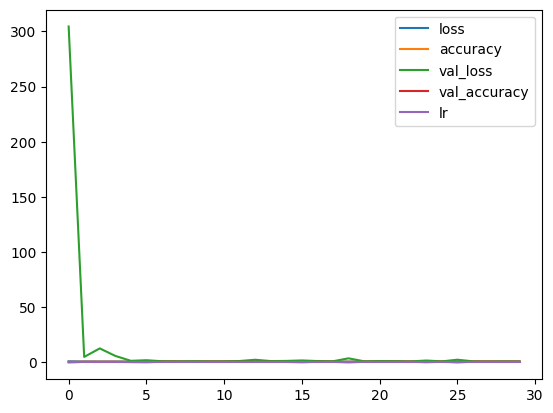

In [76]:
pd.DataFrame(history_UNETR.history).plot()

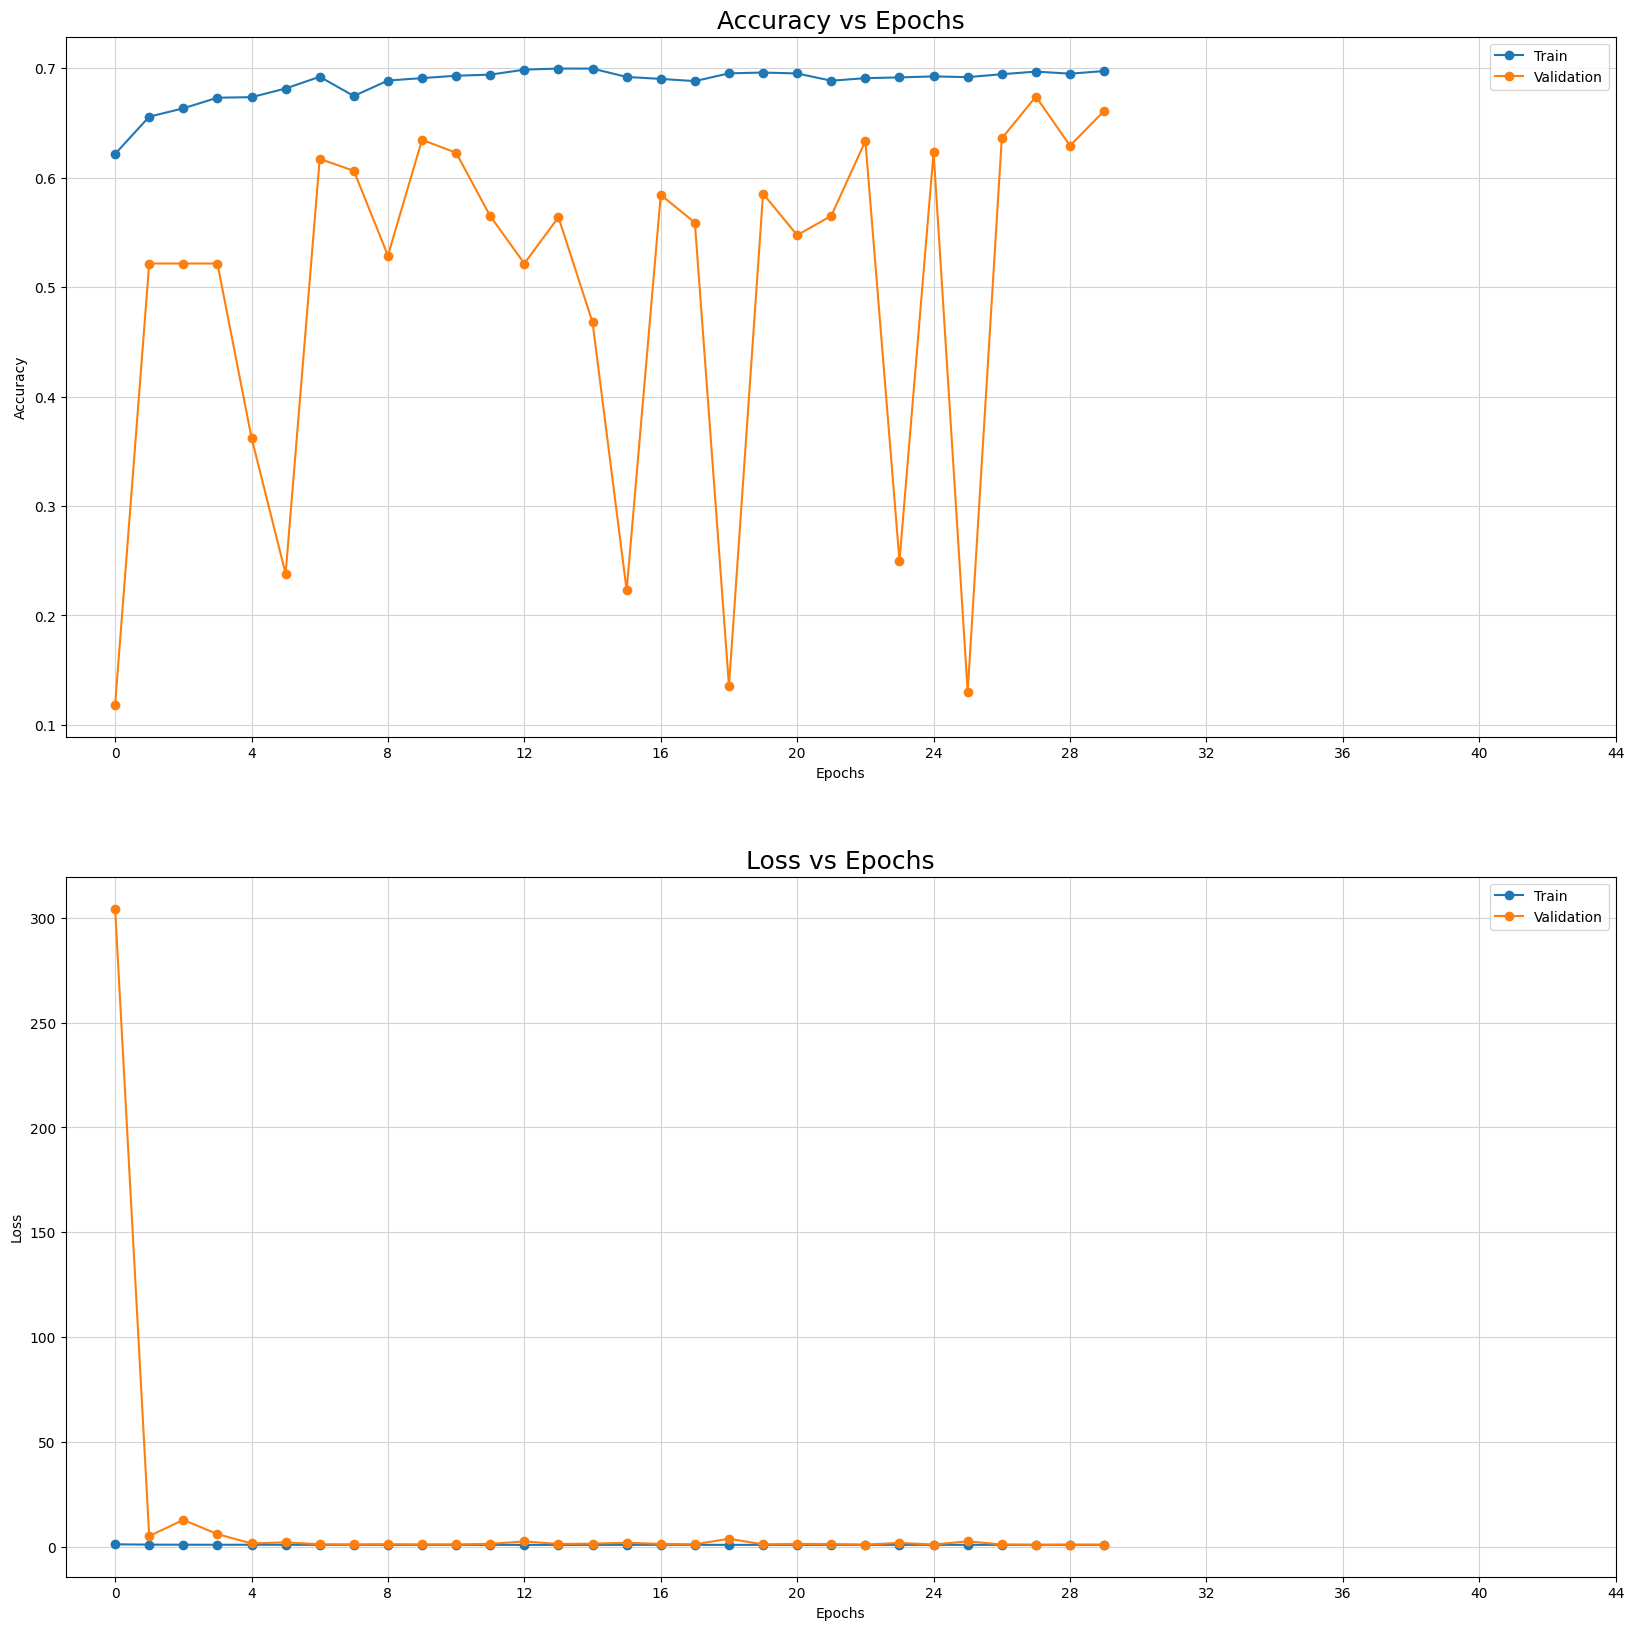

In [77]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax = ax.ravel()
metrics = ['Accuracy', 'Loss']

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_UNETR.history[met], 'o-')
    ax[i].plot(history_UNETR.history['val_' + met], 'o-')
    ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")

In [78]:
UNETR_model.save("./drive/MyDrive/Colab Notebooks/Multiclass_segmentation_UNETR_CNN_ViT_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Result

In [79]:
# Comparing Acc & Loss of models
# CNN UNet
val_loss_CNN_Unet = history_unet.history['val_loss']
val_acc_CNN_Unet = history_unet.history['val_accuracy']

# VGG19 UNet
val_loss_VGG19_Unet = history_VGG19.history['val_loss']
val_acc_VGG19_Unet = history_VGG19.history['val_accuracy']

# DenseNet UNet
val_loss_Densenet_Unet = history_Densenet.history['val_loss']
val_acc_Densenet_Unet = history_Densenet.history['val_accuracy']

# Attention UNet
val_loss_Attention_unet = history_Attention_unet.history['val_loss']
val_acc_Attention_unet = history_Attention_unet.history['val_accuracy']

# # UNETR
val_loss_UNETR = history_UNETR.history['val_loss']
val_acc_UNETR = history_UNETR.history['val_accuracy']

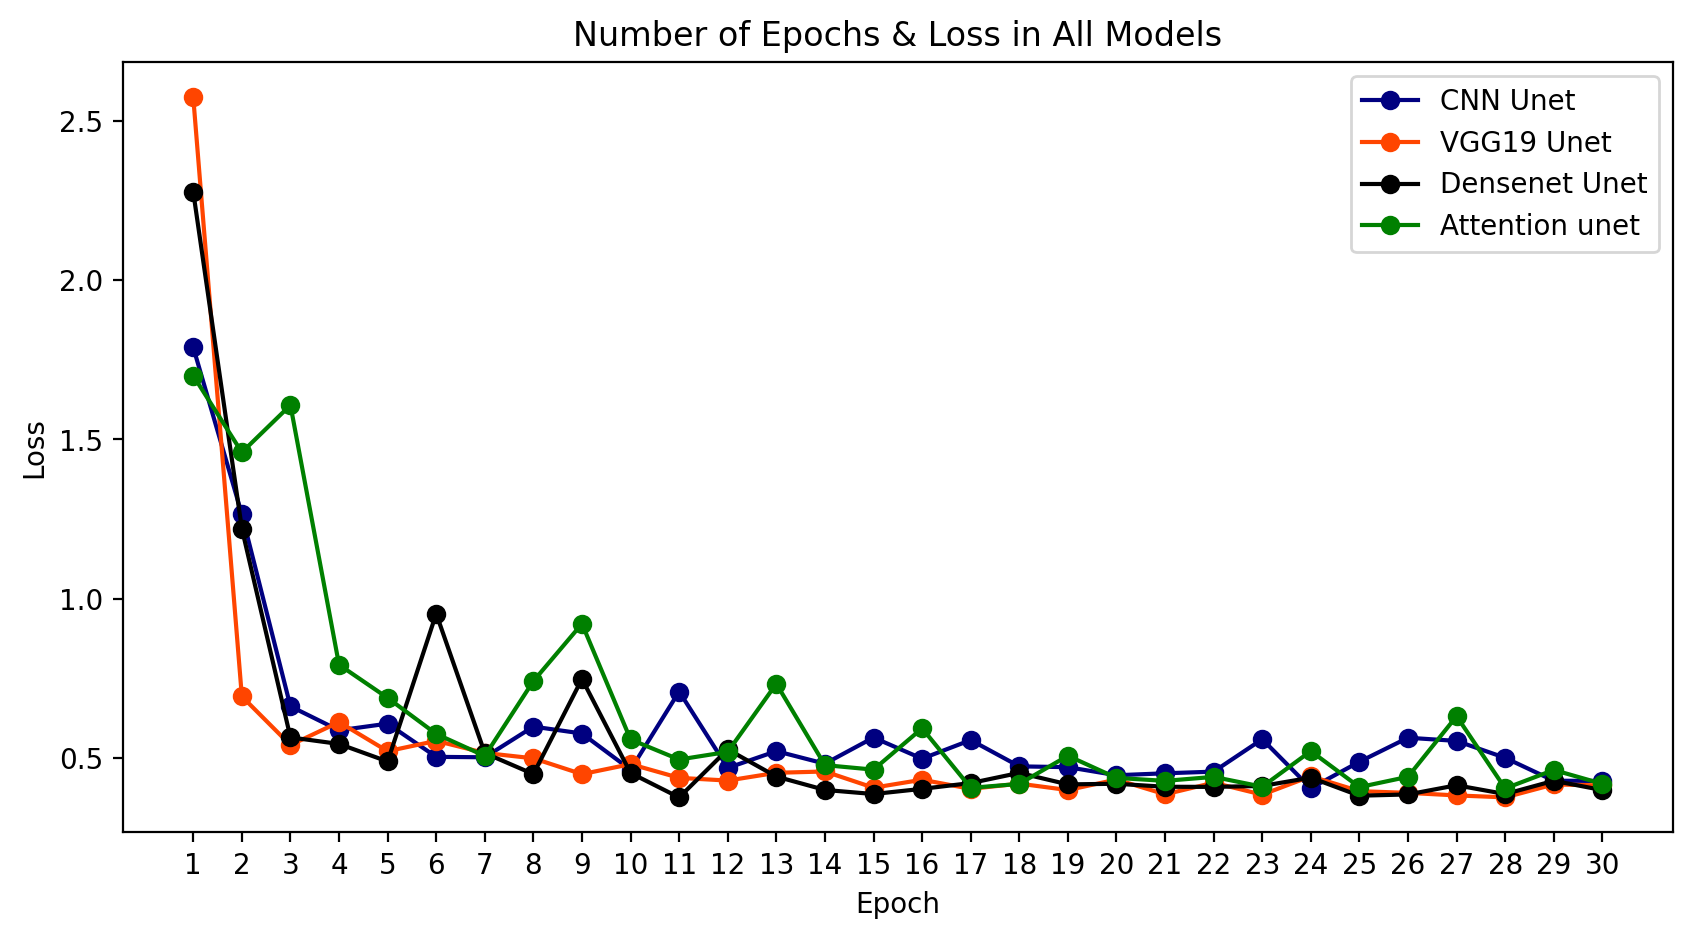

In [87]:
epoch_count = range(1, len(val_loss_CNN_Unet) + 1)
plt.figure(figsize=(10,5), dpi=200)

plt.plot(epoch_count, val_loss_CNN_Unet, 'o-',color= 'navy', label='line with marker')
plt.plot(epoch_count, val_loss_VGG19_Unet, 'o-',color= 'orangered', label='line with marker')
plt.plot(epoch_count, val_loss_Densenet_Unet, 'o-',color= 'black', label='line with marker')
plt.plot(epoch_count, val_loss_Attention_unet, 'o-',color= 'green', label='line with marker')
plt.legend(['CNN Unet', 'VGG19 Unet','Densenet Unet', 'Attention unet'])
plt.title('Number of Epochs & Loss in All Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,31,1))
plt.show();

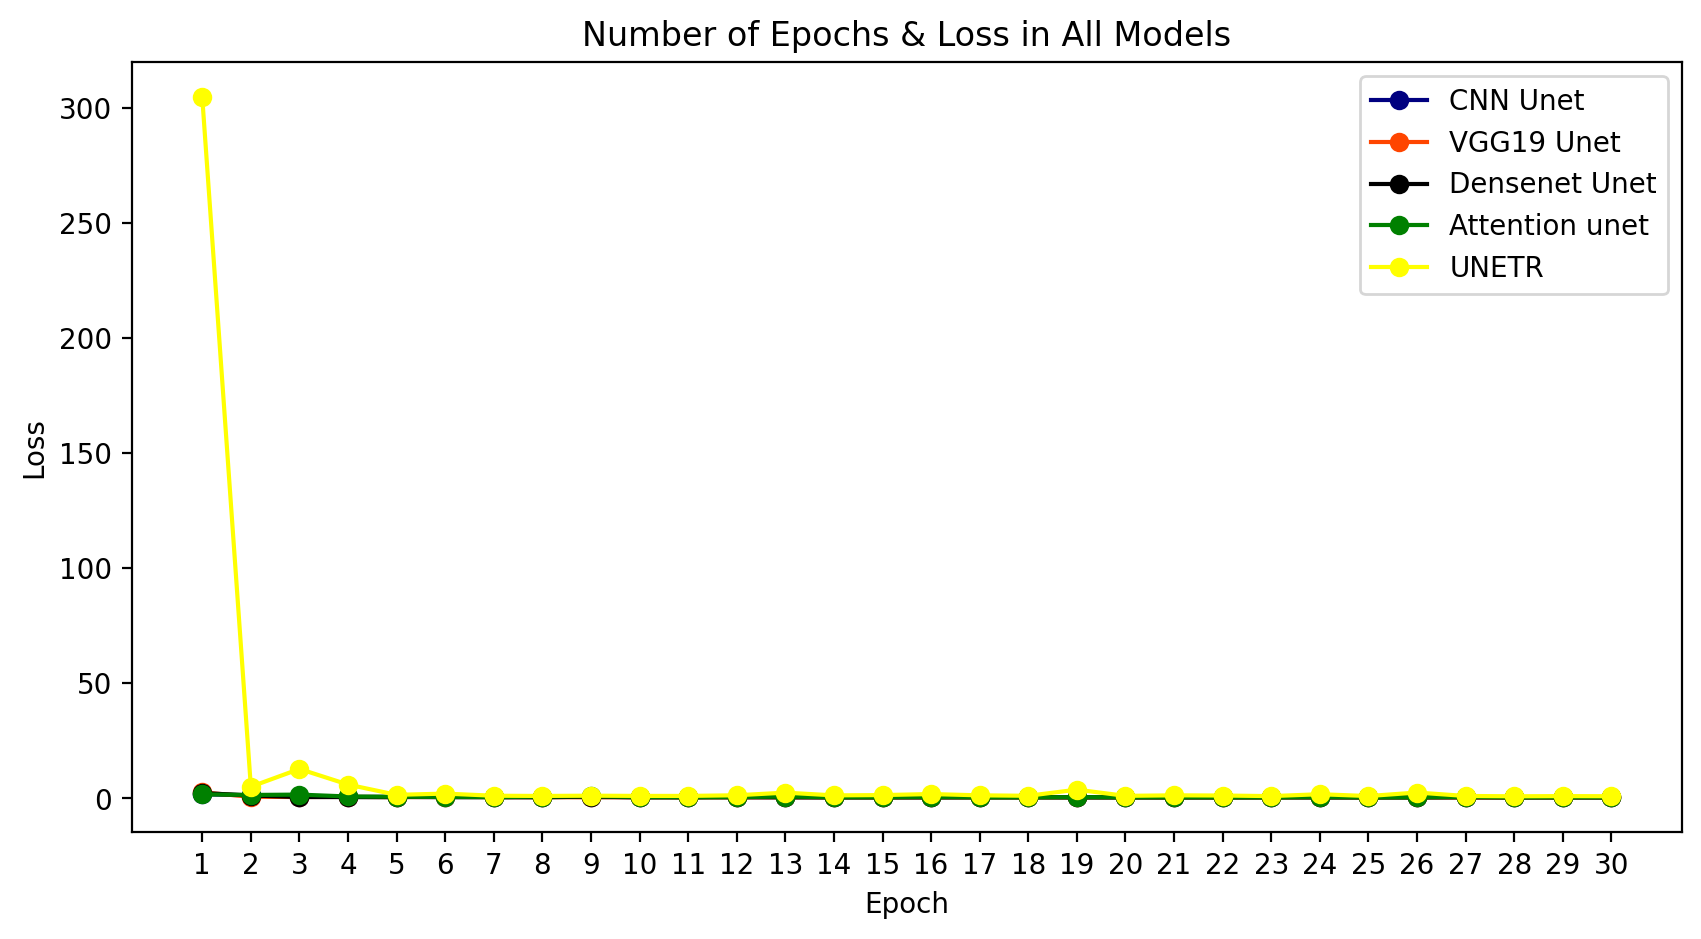

In [82]:
epoch_count = range(1, len(val_loss_CNN_Unet) + 1)
plt.figure(figsize=(10,5), dpi=200)

plt.plot(epoch_count, val_loss_CNN_Unet, 'o-',color= 'navy', label='line with marker')
plt.plot(epoch_count, val_loss_VGG19_Unet, 'o-',color= 'orangered', label='line with marker')
plt.plot(epoch_count, val_loss_Densenet_Unet, 'o-',color= 'black', label='line with marker')
plt.plot(epoch_count, val_loss_Attention_unet, 'o-',color= 'green', label='line with marker')
plt.plot(epoch_count, val_loss_UNETR, 'o-',color= 'yellow', label='line with marker')
plt.legend(['CNN Unet', 'VGG19 Unet','Densenet Unet', 'Attention unet', 'UNETR'])
plt.title('Number of Epochs & Loss in All Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,31,1))
plt.show();

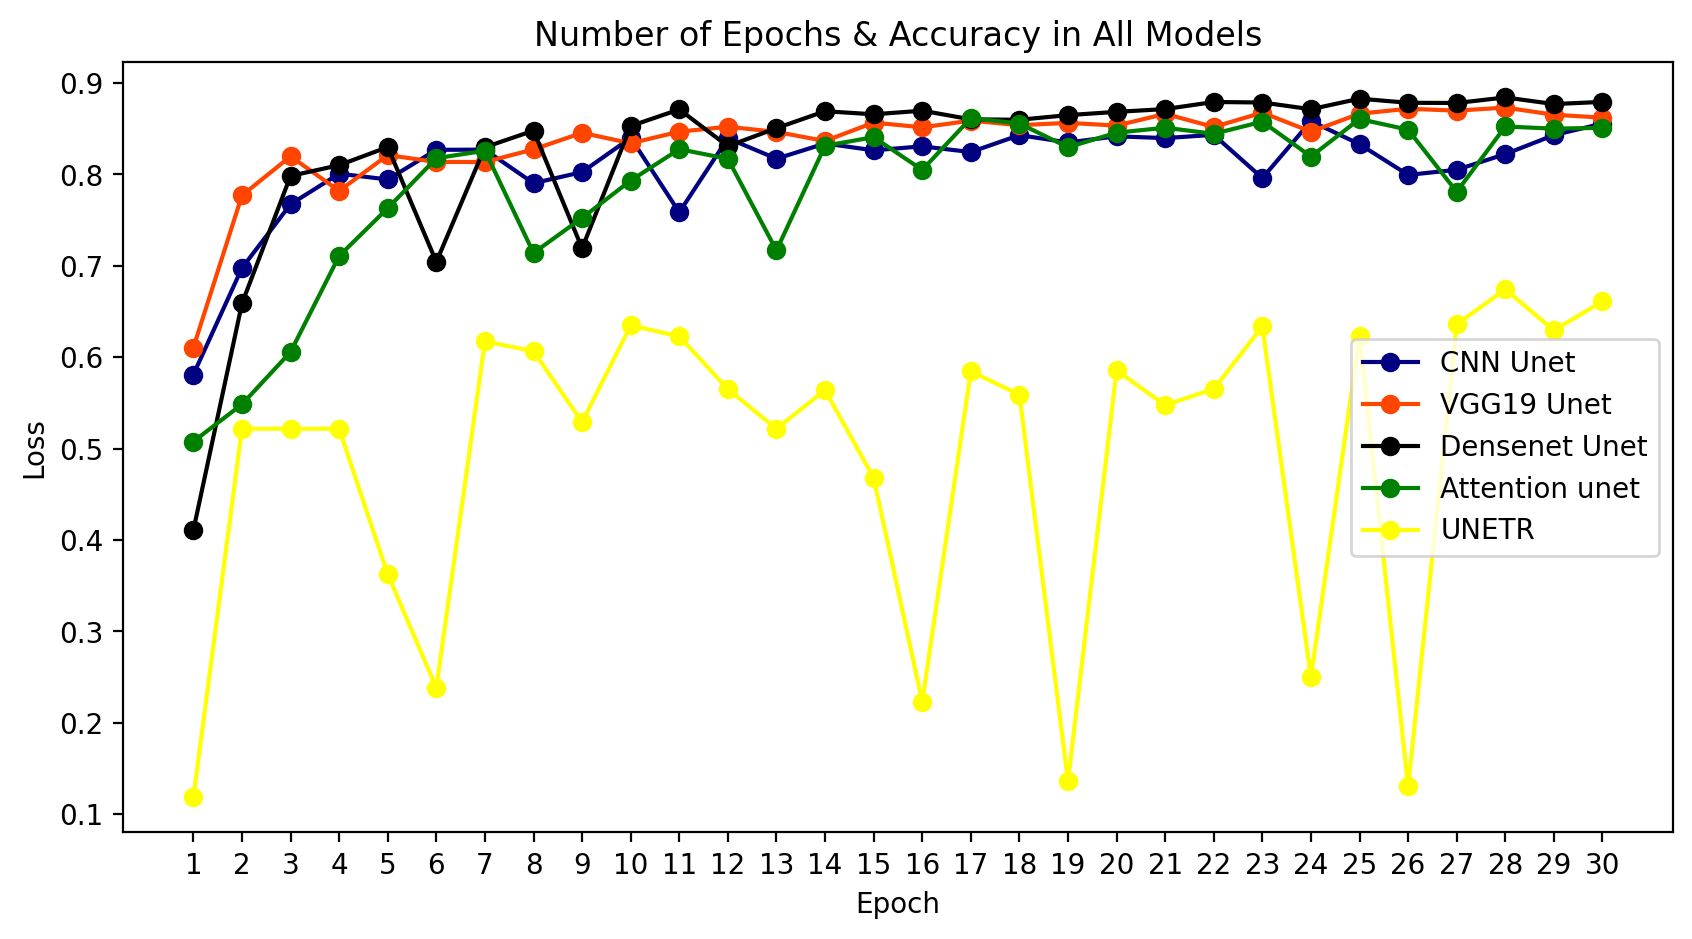

In [83]:
plt.figure(figsize=(10,5), dpi=200)

plt.plot(epoch_count, val_acc_CNN_Unet, 'o-',color= 'navy', label='line with marker')
plt.plot(epoch_count, val_acc_VGG19_Unet, 'o-',color= 'orangered', label='line with marker')
plt.plot(epoch_count, val_acc_Densenet_Unet, 'o-',color= 'black', label='line with marker')
plt.plot(epoch_count, val_acc_Attention_unet, 'o-',color= 'green', label='line with marker')
plt.plot(epoch_count, val_acc_UNETR, 'o-',color= 'yellow', label='line with marker')
plt.legend(['CNN Unet', 'VGG19 Unet','Densenet Unet', 'Attention unet', 'UNETR'])
plt.title('Number of Epochs & Accuracy in All Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,31,1))
plt.show();

In [84]:
# load models
satellite_model_unet = load_model('./CNN_Unet.h5', compile=True, safe_mode=True)
satellite_model_VGG19 = load_model('./VGG19_Unet.h5', compile=True, safe_mode=True)
satellite_model_Densenet = load_model('./Densenet_Unet.h5', compile=True, safe_mode=True)
satellite_model_Attention_unet = load_model('./Attention_Unet.h5', compile=True, safe_mode=True)
satellite_model_UNETR = load_model('./drive/MyDrive/Colab Notebooks/Multiclass_segmentation_UNETR_CNN_ViT_Model.h5', compile=True, safe_mode=True)

In [86]:
# Comparing Acc & Loss of models
loss_unet,acc_unet= satellite_model_unet.evaluate(X_test, y_test, verbose=1)
print("accuracy CNN Unet:", acc_unet , " | ", "loss CNN Unet:", loss_unet)
loss_VGG,acc_VGG= satellite_model_VGG19.evaluate(X_test, y_test, verbose=1)
print("accuracy VGG19:", acc_VGG , " | ", "loss VGG19:", loss_VGG)
loss_Densenet,acc_Densenet= satellite_model_Densenet.evaluate(X_test, y_test, verbose=1)
print("accuracy Densenet-121:", acc_Densenet , " | ", "loss Densenet-121:", loss_Densenet)
loss_Attention_unet,acc_Attention_unet= satellite_model_Attention_unet.evaluate(X_test, y_test, verbose=1)
print("accuracy Attention Unet:", acc_Attention_unet , " | ", "loss Attention Unet:", loss_Attention_unet)
loss_UNETR,acc_UNETR= satellite_model_UNETR.evaluate(x_test, y_test, verbose=1)
print("accuracy UNETR:", acc_UNETR , " | ", "loss UNETR:", loss_UNETR)

9/9 [==============================] - 0s 49ms/step - loss: 0.4284 - accuracy: 0.8556
accuracy CNN Unet: 0.855624258518219  |  loss CNN Unet: 0.4283624589443207
9/9 [==============================] - 1s 55ms/step - loss: 0.4143 - accuracy: 0.8621
accuracy VGG19: 0.8621176481246948  |  loss VGG19: 0.41425856947898865
9/9 [==============================] - 1s 54ms/step - loss: 0.3997 - accuracy: 0.8793
accuracy Densenet-121: 0.8793402910232544  |  loss Densenet-121: 0.3997025787830353
9/9 [==============================] - 1s 90ms/step - loss: 0.4193 - accuracy: 0.8509
accuracy Attention Unet: 0.8509402275085449  |  loss Attention Unet: 0.4193003177642822
9/9 [==============================] - 7s 488ms/step - loss: 0.9151 - accuracy: 0.6611
accuracy UNETR: 0.6610601544380188  |  loss UNETR: 0.9150939583778381


In [89]:
# make prediction
y_pred_unet=satellite_model_unet.predict(X_test)
y_pred_VGG19=satellite_model_VGG19.predict(X_test)
y_pred_Densenet=satellite_model_Densenet.predict(X_test)
y_pred_Attention_unet=satellite_model_Attention_unet.predict(X_test)


y_pred_argmax_inception=np.argmax(y_pred_unet, axis=3)
y_pred_argmax_VGG19=np.argmax(y_pred_VGG19, axis=3)
y_pred_argmax_Densenet=np.argmax(y_pred_Densenet, axis=3)
y_pred_argmax_Attention_unet=np.argmax(y_pred_Attention_unet, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


9/9 [==============================] - 1s 85ms/step


1/1 [==============================] - 0s 24ms/step


NotFoundError: Graph execution error:

Detected at node model_1/layer_normalization/add defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-88-69065174c86a>", line 6, in <cell line: 6>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/layer_normalization.py", line 343, in call

No registered '_MklLayerNorm' OpKernel for 'GPU' devices compatible with node {{node model_1/layer_normalization/add}}
	.  Registered:  device='CPU'; T in [DT_BFLOAT16]
  device='CPU'; T in [DT_FLOAT]

	 [[model_1/layer_normalization/add]] [Op:__inference_predict_function_280413]

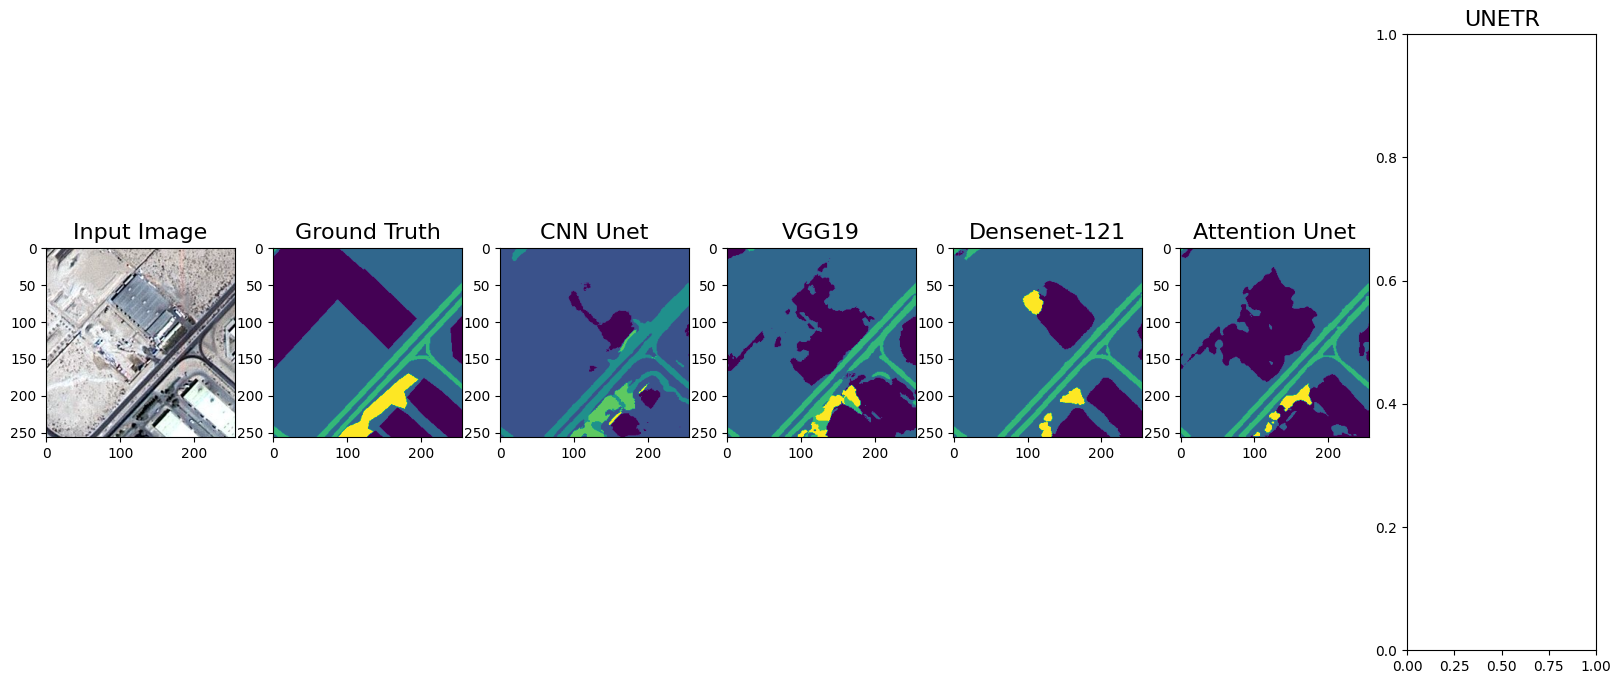

In [91]:
for i in range(3,7):
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1,7,1)
    ax1.imshow(X_test[i])
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax1.grid(False)

    ax2 = fig.add_subplot(1,7,2)
    ax2.set_title('Ground Truth', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.imshow(y_test_argmax[i])
    ax2.grid(False)

    ax3 = fig.add_subplot(1,7,3)
    ax3.set_title('CNN Unet', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.imshow(np.argmax(satellite_model_unet.predict(np.expand_dims(X_test[i], 0)), axis=3)[0,:,:])
    ax3.grid(False)

    ax4 = fig.add_subplot(1,7,4)
    ax4.set_title('VGG19', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax4.imshow(np.argmax(satellite_model_VGG19.predict(np.expand_dims(X_test[i], 0)), axis=3)[0,:,:])
    ax4.grid(False)

    ax5 = fig.add_subplot(1,7,5)
    ax5.set_title('Densenet-121', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax5.imshow(np.argmax(satellite_model_Densenet.predict(np.expand_dims(X_test[i], 0)), axis=3)[0,:,:])
    ax5.grid(False)

    ax6 = fig.add_subplot(1,7,6)
    ax6.set_title('Attention Unet', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax6.imshow(np.argmax(satellite_model_Attention_unet.predict(np.expand_dims(X_test[i], 0)), axis=3)[0,:,:])
    ax6.grid(False)

    ax7 = fig.add_subplot(1,7,7)
    ax7.set_title('UNETR', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax7.imshow(np.argmax(satellite_model_UNETR.predict(np.expand_dims(x_test[i], 0)), axis=3)[0,:,:])
    ax7.grid(False)

    plt.show()